# KOTY VS PSY

# Twitter

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from wordcloud import WordCloud

import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

import snscrape.modules.twitter as sntwitter

import pandas as pd

from langdetect import detect

from googletrans import Translator

from sentimentpl.models import SentimentPLModel

from langdetect import detect

from text2emotion import get_emotion

from geopy.geocoders import Nominatim

import country_converter as coco

import warnings

warnings.filterwarnings("ignore")


# Do znajdowania panstwa po kordynatach
cc = coco.CountryConverter()

# Inicjalizacja obiektu geokodera
geolocator = Nominatim(user_agent = "my-app")

# Ocenia neutralnosc, pozytywnosc i negatywnosc
model = SentimentPLModel(from_pretrained = 'latest')

2023-06-05 10:50:05.550818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zosiasiwiec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zosiasiwiec/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zosiasiwiec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def zamiana_nazwy_panstwa(country_id):
    if country_id == "Brasil":
        country_id = 'Brazil'
    elif country_id == 'Ελλάς':
        country_id = 'Greece'
    elif country_id == 'Österreich':
        country_id = 'Austria'
    elif country_id == "United States":
        country_id = 'United States of America'
    elif country_id =='Deutschland':
        country_id = 'Germany'
    elif country_id == 'Slovensko':
        country_id = 'Slovakia'
    elif country_id =='België / Belgique / Belgien':
        coutnry_id = 'Belgium'
    elif country_id == 'Česko':
        country_id = 'Czechia'
    elif country_id == 'España':
        country_id = 'Spain'
    elif country_id == 'México':
        country_id = 'Mexico'
    elif country_id == 'Nederland':
        country_id = 'Netherlands'
    elif country_id == 'Србија':
        country_id = 'Serbia'
    elif country_id == 'ประเทศไทย':
        country_id = 'Thailand'
    elif country_id == 'Sverige':
        country_id = 'Sweden'
    elif country_id == 'Polska':
        country_id ='Poland'
    elif country_id == 'Norge':
        country_id = 'Norway'
    elif country_id == '日本':
        country_id = 'Japan'
    elif country_id == '中国':
        country_id = 'China'
    elif country_id == 'Schweiz/Suisse/Svizzera/Svizra':
        country_id = 'Switzerland'
    elif country_id == 'বাংলাদেশ':
        country_id = 'Bangladesh'
    elif country_id == 'السعودية':
        country_id = 'Saudi Arabia'
    elif country_id == 'پاکستان':
        country_id = 'Pakistan'
    elif country_id == 'مصر':
        country_id = 'Egypt'
    elif country_id == 'Danmark':
        country_id = 'Denmark'
    return country_id

In [3]:
def get_tweets(hasztag):
    tweet_list = []


    default_stopwords = stopwords.words('english') 
    additional_stopwords = ['``', '.', '\'\'',',','...','?',':','(',')'] # //, '@' , '!', '#'
    stopwords_list = default_stopwords + additional_stopwords
    lemmatizer = WordNetLemmatizer()
    sia = SentimentIntensityAnalyzer()

    i = 0

    for tweet in sntwitter.TwitterSearchScraper(hasztag).get_items():
        if i >= 100:
            break
        
        #biore tweety bez pustego tekstu i z koordynatami
        if tweet.rawContent != "" and tweet.coordinates is not None:
            print(tweet.content)
            try:
                language = detect(tweet.content)
            except:
                print('brak jezyka')
                language = ''
                
            #analiza polskich tweetów i angielskich
            
            if language == "pl":
                #tokenizacja
                tokens = word_tokenize(str(tweet.content).lower(), language = 'polish')
                #filtruje przez stopwordsy
                filtered_tokens = [token for token in tokens if token not in stopwords_list]
                #zmiana formy na podstawową
                lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
                #licze wartość oceny(sentymentu), dziele przez długość żeby dłuższe tweety nie miały
                #większej oceny - uśredniam
                suma = 0
                for token in lemmatized_tokens:
                    suma += model(str(token)).item() / len(lemmatized_tokens)
                emocje = None
                #przypisuje nazwe panstwa na podstawie koordynatów
                location = geolocator.reverse((float(tweet.coordinates.latitude), 
                                            float(tweet.coordinates.longitude)))
                try:
                    country_id = location.raw['address']['country']
                    country_id = zamiana_nazwy_panstwa(country_id)
                    country_id = cc.convert(names = country_id, to = 'name_short')
                except:
                    country_id = 'not_found'
                country_id = zamiana_nazwy_panstwa(country_id)
                tweet_list.append(['pl', country_id, tweet.date, tweet.id, tweet.content, tweet.user.username,
                            tweet.coordinates, tokens, filtered_tokens, lemmatized_tokens, suma, emocje])
                i += 1
            
            elif language == 'en':
                tokens = word_tokenize(str(tweet.content).lower(), language = 'english')
                filtered_tokens = [token for token in tokens if token not in stopwords_list]
                lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
                suma = 0
                for token in lemmatized_tokens:
                    suma += sia.polarity_scores(token)['compound'] / len(lemmatized_tokens)
                emocje = get_emotion(tweet.content)
                location = geolocator.reverse((float(tweet.coordinates.latitude), 
                                               float(tweet.coordinates.longitude)))
                try:
                    country_id = location.raw['address']['country']
                    country_id = zamiana_nazwy_panstwa(country_id)
                    country_id = cc.convert(names = country_id, to = 'name_short')
                except:
                    country_id = 'not_found'
                country_id = zamiana_nazwy_panstwa(country_id)    
                tweet_list.append(['en', country_id, tweet.date, tweet.id, tweet.content, tweet.user.username,
                            tweet.coordinates, tokens, filtered_tokens, lemmatized_tokens, suma, emocje])
                i += 1

    twitter = pd.DataFrame(tweet_list, columns = ['Język', 'Panstwo', 'Datetime', 'Tweet Id', 'Text', 'Username',
                                               'Koordynaty', 'Tokeny', 'Filtrowane_tokeny', 'Lematyzacja',
                                               'Wynik_opinii', 'Emocje'])
    return twitter

In [4]:
import spacy
from spacy.lang.pl.examples import sentences 

nlp = spacy.load("pl_core_news_lg")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)
    
print(doc)

Poczuł przyjemną woń mocnej kawy.
Poczuł VERB ROOT
przyjemną ADJ amod
woń NOUN obj
mocnej ADJ amod
kawy NOUN nmod:arg
. PUNCT punct
Poczuł przyjemną woń mocnej kawy.


In [5]:
# the following installations are required
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('pl_core_news_lg')
nlp.add_pipe('spacytextblob')
text = 'mialem straszny dien. byl fatalny. jestem przerażony'
doc = nlp(text)
print(doc._.blob.polarity)                            # Polarity: -0.125
print(doc._.blob.subjectivity)                       # Subjectivity: 0.9
print(doc._.blob.sentiment_assessments.assessments)   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]
print(doc._.blob.ngrams())

0.0
0.0
[]
[WordList(['mialem', 'straszny', 'dien']), WordList(['straszny', 'dien', 'byl']), WordList(['dien', 'byl', 'fatalny']), WordList(['byl', 'fatalny', 'jestem']), WordList(['fatalny', 'jestem', 'przerażony'])]


In [6]:
twitter = get_tweets('kotki') 

@jestemkejti @LeszekJarema Ja również . Seria z Gogh. Kotki i pieski …
kocham fakt ze jak mam otwarte okno to doslownie 24/7 slysze jak mialcza kotki bo z obu stron mieszkania ludzie maja i to moja ulubiona aktywnosc patrzec i zgadywac ktory mialcze
@basiulowo @kot_malinek Te kotki zostały tak udomowione (wnuki) w stosunku do poprzednich że nawet nie myślą o przenoszeniu swoich pociech celem bezpieczeństwa. Poprzednie codziennie w nocy przenosiły i chowały - te w pełni ufają człowiekowi i przy samej kotce mogę pomiziać maleństwo 😉
@dorotagma Dwie kotki siostry się okociły u mojej cioci - same mają około roku, ale te małe kluseczki są tak śliczne, że wyjść tam od nich nie mogłem. Razem 4 małe pociechy 😍🥰🤗 https://t.co/S8xQJoe5Bs
Kocham kotki 🤩🥹 https://t.co/YQ9xi11EVg
@GosiaBajorek Bo nie mogę Giertycha. To kotki.
@aka1971 @MioCaffe1 @Antonio25513549 Kotki groźne. Łapiom marchewki
Jest dowód. Zdjęcie robione tosterem https://t.co/HmOfaBnoQP
matka kupiła balony bo będzie w pracy robić z 

België / Belgique / Belgien not found in regex


@Chamaedorea_P @RADIO_REBELIANT Totalnie się zgadzam! Moja koteczka najmłodsza ma 6 miesięcy, mam 4 kotki w sumie, cała pozostała trójka jest wykastrowana i Basia tez będzie!
@Basiowe_kotki Powiedział bym bardzo zacnie Basiu 😊
@PaniNowakowa Aaa kotki dwa 😃Buzinek na ta komende od razu uklada sie w lozeczku i spi 😴❤️🐕‍🦺


België / Belgique / Belgien not found in regex


Może ja jednak bym kotki i widoczki wrzucał? Obmierzła mi już ta polityka. Bagno gnojowicy, a nie polityka.
@Antonina_Ow Co jeden to piękniejszy. Cudne kotki
@kociu91 @pluszysta @Basiowe_kotki @Paula__88 @owlbrom @PestkaPL @misia_domi Pozdrawiam, nocując u znajomych po przebudzeniu od razu musiałem wypełnić obowiązki 😼 https://t.co/4HKMoVFgL7
@kot_malinek Ładne macie te brytyjskie kotki 😻
Znaleziono kota, Wrocław
Liwia (155/23) Zainteresowanych adopcją kotki prosimy o przesłanie (...)
https://t.co/F5ac42jWZk
#znalezionokota #znaleziono #kot #wrocław https://t.co/zbIXOTYIn8
@JoannaJaKB A kotki nie? https://t.co/tAXmpLBo1m
@ErdmannGrzegorz @An7008 Aaa kotki dwa 😴😴😴 https://t.co/2jMmD9u1Oh


België / Belgique / Belgien not found in regex


@JoannaJaKB Nie mam piesków 😱,kotki owszem 😁
@Bajarka1 Faktem, jest że nie u mnie, ale moja bliska kuzynka przygarnęła te dwie istoty bezdomne a jej mama 3 kotki 😉 https://t.co/xFmIa7Vuac
@Basiowe_kotki Gimbal mam, polecam, tylko trzeba się nauczyć „skrótów”, przełączania trybów klawiszami
@kociu91 @LEGO_Group @karo_yard @r0br3t @robsoniqe @mobzillatv @Basiowe_kotki @JohnManham @misia_domi Mam zestaw 6957 i 6247, ale tak poza tym mam to👌🏼 https://t.co/PVi4mtHgNk
Kochani, może ktoś słyszał/widział. Szukamy kotki do adopcji. Najchętniej starszej, min 5letniej. 
Może być niewidoma.Musi się dogadywać z innymi kotami,bo zajmie miejsce Miłeczki, obok Trunia, statecznego, spokojnego, dojrzałego i opiekuńczego kocurka. 
Podrzucajcie jbc! Dzieki!
Kochani kociarze, Rosołek ostatnio znacznie częściej domaga się jedzenia, czy to są jakieś sezonowe zmiany, wasze kotki na wiosnę jedzą więcej? czy mam się martwić?
@AgaHerrmann Dzisiaj ciocię odwiedziłem, jej kotki tak mnie polubiły że odczepić się ni

Stopping after 20 empty pages


In [7]:
hasze = ['cutecat', 'kities', 'cat', 'słodkiekotki', 'catlady', 'kociara', 'koteczki', 'kociświat',
        'kitty']
for hasz in hasze:
    twitter2 = get_tweets(hasz) 
    twitter = pd.concat([twitter, twitter2])

Oh to be a cat - infinite naps and endless food! That's the dream life 🐈😽💤🖤 

#CatsOfTwitter #CatsOnTwitter #jellybellyfriday #fridaymorning #FridayMood #FridayFeeling #FridayThoughts #FridayVibes #Friday #Friyay #AdoptDontShop #CatsAreFamily #CatLovers #cat #cats #cutecat https://t.co/mbZdU4r6kz
Who else put a car air freshener on a door knob instead of on the back mirror of the car? Calico cat is having so much fun playing with it!😸

Pre-Order Here: https://t.co/rcs9dLrY8o

#artmoots #cuteart #Caturday #CatsOfTwitter #calicocat #cutecat https://t.co/xujqZ1OpiL
Sun's Out Tongues Out! ☀️👅😼 #tongueouttuesday 

#CatsOfTwitter #CatsOnTwitter #tuesday #tuesdayvibe #TuesdayFeeling #tuesdaymotivations #sunny #CatsAreFamily #CatLovers #cute #cutecat #cat #cats #meow #tongue #Cyprus https://t.co/nq2v5G77xH
Circa 2015-2016, @phillypaws #NortheastPhilly location.

This #littledude was hamming it up in the free-roaming #cat room! What a #HAM !

#AdoptDontShop #ShelterPets #cutecat #CatsAreFamily 

Stopping after 20 empty pages


@scrag_cat @Nacho87329549 @Leonlovescats Kities going around in limo with Scragers around all the pub crawl
@CristianPoleroo Aca te dejo otra kities https://t.co/kewmi1KX8W
@CristianPoleroo El 24 me mando para allá kities
"¿Puedo llevarte a un momento
donde los campos están pintados de oro, y los árboles están llenos de recuerdos de los sentimientos nunca confesados?" Bloom ~ The Paper Kities https://t.co/WIWtY7fBCj
@CristianPoleroo Vamo arriba kities usted sabe que acá estamos , vamos a meter noche loca
Tati dan pena ajena...tu hello kities
@paranoidhill @LisaODT Ahahaha yessss many many kities! 😻
@coruscantly Bacanya bukan kities
ya hamry city gujranawala ki  Ik boht peyara idara cia h us ki building k uper kities fly ho rahi h  aur hamri police aram k sath apnry rooms ma aram farma h  in police walo ko koi parwa nai h in kities fly karny walo ki wja sa kisi ki jan chali jay bas hmry police officero ko https://t.co/2Tw2DpaElo
gujranwla ka cia ki building k uper kities fly  ho rahi h 

Stopping after 20 empty pages


Idk WTD with this reeking cat litter smell in our shared area 😓
Posant fil a l'agulla... @cnea_cat @xarxadeparcs
Funny cat Pressed wrong Button  🤣 https://t.co/nPpIeAAw8k 來自 @YouTube
@pitchaijohn1961 @vivekagnihotri He is Lion cat https://t.co/IOKqGOu9hZ
Funny cat Pressed wrong Button  🤣 https://t.co/nPpIeAzYiM 來自 @YouTube
@whitepersian @Zach_Gold__ @POTUS No one asked a stray cat
After the traffic it's raining cats and dogs
@Hardy2hardy190 @Mike59765518 @ErickWeber SHE WAS NOT THE STAR. You can’t keep saying CATS all you want. You have no sense of context when making your arguments
5 kedi 1 köpüş annesi Cat 🥰😻🐾🐶💕
#gato #cat #catlover #anne #mom #bebek #köpek #dog #aşk #kalp #baby https://t.co/fOSUn0tWHu
Boss came back from annual leave this morning and said ‘thank you for holding the fort. I didn’t worry about work the entire time I was away’. 😍

I felt like high fiving strangers! 

It’s a world away from being micromanaged and being the cat that is constantly kicked. 👌
@Carla_and_cat

عمان not found in regex


What a person wants is to be beautiful, pleasant, fun. It will be pop music, flowers, cats. Therefore, museums never listen to people, so as not to become slaves to the average taste.


Azərbaycan not found in regex


@yoshiki69k @CleGuardians @NewEraCap 教え下さりありがとうございます😭　Guardian のGにしてはCぽいよなと思ってました　胸張ってかぶれます☺️👍
@josue_ziemer Amém meu amigo querido 🙌 Igualmente pra você 🙌🤗☕️🇧🇷
Bay kemalciler okusun ve yine gidip oy versin.
🚂 ➡️ Marseille
Pour Les Huguenots. Pour la vue sur le Vieux Port. https://t.co/Jbt6Ldgn1A
Good morning to everyone but especially to the cat that finds this https://t.co/Ko2nWJd0iK
@Ingeborgvraagt Negatief: minder haar, meer kilo's
Positief: mijn leven is een stuk leuker met @Carla_and_cats. Zij is leuk, zelfs al moet ik regelmatig het onderspit delven in haar whatsapp-tirades. https://t.co/MQ4j8kUXc5
@laufeyso0n cat 3 barat https://t.co/uMdJypRILA
@cat_auras Aku adalah botol
@Shi323232 The cat is doing a better job tbh 🤦🏻‍♂️😂
cute cat&amp;Carb https://t.co/5uQiA7w2Xx 來自 @YouTube
@DrEaM0pErAt0r Cat person. Addicted to rape and feeling like ur the best thing someone will ever touch.
Im selling 2x tickets (CAT 1) for CHAMPIONS LEAGUE FINAL. Real and demonstrable. Send a direct messag

Could not translate t.co card URL on tweet 1665563666186633216


@PPDD26283011 กลายเป็นวัยรุ่นใจแตกเฉย งื้ออออ ❤️‍🩹
生活是一个磨盘，我把自己放上去，看着它一点点碾碎我的一切
@cat_ded_mitiay А в Москве в КиБ яйца по 68 р за 10, вполне нормальные по размеру и вкусу)
Wille has a cat, all is well with the world I say!!!☺️🙌🏾🙌🏾🤗👌🏾….. Simon, not you complimenting the CAT, say how you really feel Simon 😂😂😂😂, def stalling here…
@ChemCatChem Thank you @ChemCatChem for your support and for this opportunity to increase awareness of RDM!
ど〜せ休憩するなら✨
「そ〜だ・亀山へ行こう！！」
風呂も有るし・温かい食事にもありつける🤗 https://t.co/kBoij29ZOK
After not attending meets up for  few years wow the revenue cat event tonight  was amazing #WWDC23
Why is it 2 cats choppin it up outside my window loud ASF😠😡🤬😤 Im thinking somebody kids outside crying n sht😭
Most of my very nearest and very dearest captured in a rare grouping. (One daughter &amp; two cats are missing). https://t.co/VwpjFUMZPr
@GMB The school cannot control who is invited to a private party whatever they say in a ‘policy’ but they could refuse to hand out the invitations

Unavailable user in card on tweet 1665614509791166470
User 1513517352775831556 not found in user refs in card on tweet 1665614509791166470


When you're gay and say "yes daddy" to Satan 😈
@hospitalclinic @pons_francesca @jmcampis @gemma6316 @castells_toni @PilarVarela17 En català!
I wonder if niggas snap on Cats, like they do women, whenever they don’t answer them in public. Can you Imagine a nigga in the street like “Here kitty kitty.. oh word? Fuck you then bitch” 💀😭
@jcrimdepensa @thio_jordi Tots dos són covardia.
@Charlie_met_i_e Si you are a green cat, eh Max
@BBtragic230387 Berry Island?
@blueemmee Ha! 🤣🤣🤣
@Ivy_the_slayer Really? Who said that?
@Ivy_the_slayer SNAP!
@0brooke0taylor Hopefully the jet has lopsided throws 🤞🏻🤞🏻🤞🏻
@blueemmee Underrated tweet https://t.co/pFoBayAPzJ
@bob_wynn 5.50am for me, Rudi shouting for the cat that didn’t come home last night. Our neighbours must hate us.
This cat person ass relationship #theidol
Guest Star Cat: This is Khole or as I like to call her Yonk.: The post Guest Star Cat: This is Khole or as I like to call her Yonk. appeared first on Katzenworld - Welcome to the world of cat

Ísland not found in regex


@jojoeyjo9 @0brooke0taylor I’ve learned so much in 36-ish years, like not falling on penises + now, hand holding is worse than kidnapping + murder!
All ladybirds are female. Is this true? Aye or Naw? 🐞🐞
@0brooke0taylor Hahaha 😝
京都府八幡市✨
１４時前に📦プラス完了✨
明日着の東京都練馬区向け✨
Ｒ１６３へ抜けて下柘植の宇佐美で給油&amp;ご休憩💕 https://t.co/rcJrZ9DjSC
Liam! Worrying about Thomas? That ship has sailed. Worry about Hope!
#ohbrookeohtaylorohbrooke
It's rude to wake somebody peacefully sleeping but I would like him to have a whiff of my fresly laundered socks. 😅🤣
I'm so bad 🤣🤣🤣
#CatsAreFamily #cats https://t.co/6VygIC1PW2
Liam C/- @BandB_CBS send the Spencer jet #ohbrookeohtaylorohbrooke
https://t.co/gaQIPI6j6Z
brak jezyka
@Cats_dogs_kit You boo T full
The main village in Pulau Aur, Kampung Teluk Berhala
The village comes with a school, grocery store, police station and jetty
No roads
No car, motorcycle, bicycle. Only sea transport, swimming or walking 
No phone coverage. Trust me!
And they have cats!!!

#fadzcrossthemap https:

Unavailable user in card on tweet 1665603465480122368
User 2267930390 not found in user refs in card on tweet 1665603465480122368


@Rez_Lizard Oh, yes... M.A.P.S. https://t.co/XnAZNNmIQY
Nici scammerii nu mai sunt ce-au fost odată 🥹

Report în număr cât mai mare 😌

Mulțumesc celor care m-ați anunțat 🙏💖🤗 you guys are the best! https://t.co/9PHRucL47B
@SherylFrase1 Good morning Sheryl😊🌼
🐈‍⬛: "Yo también quiero enseñar mis patitas"... 🐾
.
https://t.co/A0jApZi0W9
.
#feetpic #feetfetiche #feetlover #michi #Cat #gatita #kitty #feet_lover #BuenosDias #goodmorning #catlovers #feetcontent #feet https://t.co/HQyFuH0tVL
@theunsungbard Fine. Just ignore my internet persona... GN! https://t.co/iN6SBAmZAA
@wumingtu_25 @cat_xiaowen0107 我猜耶耶他一直挂账号了……🍊盗图看不出来吧 我只是猜测…
@saepulohkece Cat 2 zona brpa bang? Mksud sy tadi 2 tiket cat 3 bang. Km adanya cat brpa?
eu vou apanhar muito pra fazer o peso em lb pqp
05 June 2023

At 08h00 (CAT) 
The 🇿🇦#ZAR opened at :

R19.53 /#USD 🇺🇸$
R24.27 / GBP 🇬🇧£
R20.90 / EUR 🇪🇺€
R12.90 / AUD 🇦🇺$
R11.84 / NZD 🇳🇿$
R14.53 / CAD 🇨🇦$

Internationalise yourself &amp; your wealth

email: Gary.davies@sableinterna

Unavailable user in card on tweet 1665600822644711425
User 2267930390 not found in user refs in card on tweet 1665600822644711425


@carp_music_cat 50円😂🤣😂🤣
@WildeOscarCat @BrendaPerrott @NYCDEATHROWCATS @morgfair @KittyLibFront These kids should have been supervised and trained on how yo handle a new cat.
Cek Lemari Plastik Lemari Pakaian Plastik Susun KACA ada KUNCI dengan harga Rp80.000 - Rp207.500. Dapatkan di Shopee sekarang! https://t.co/oZkOzT9Jan
PARAJuara Indonesia vs Argentina jungkook Pendekar PSHT Zlatan CAT 3 Selamat Hari Raya Waisak Buddha Dompet Jogja Formula E https://t.co/OHcQODZaME
@neueskapput Peliculón 3 estrellas
@jaipcat @JuntsXCat @PSOE @socialistes_cat Tranquil, que 4 anys pasen aviat, igual d'aviat com a Sant Cugat, Figueres, Tàrrega ...
O ja no ho recordes ??
@Spireship 82 was a great year for film but CE3K came out in 77. ET was released in 82 as was Blade Runner, Tron, The Thing, First Blood, Wrath of Khan, Dark Crystal, Conan, and of course Cat People.
@GovernorShapiro Dirty degenerate
@Mutti88080561 うんうん💦
@Nabanit77735158 @rockinglife10 Just bcos she put up a video of Fahmaan and his ca

België / Belgique / Belgien not found in regex


@the_lettuce_cat *raises hand*

Foamer/transit nerd Swiftie here visiting Chicago for the show. Almost got screwed by the Blue Line (we are staying at O'Hare) but next train went from 19 to 5 mins in a flash after changing at Jackson
https://t.co/WKrB05e6cp
brak jezyka
Why is my gaming TL now just full of street fights and shootings? I don’t even recognize Twitter anymore?
@barcastuff_idn Dpt cat 4
@KenM50Ontos @hodgetwins Only American cowardly cops that shoot everything that moves away from them at barely running pace. And most of the cops in America are probably decent, it’s the cowardly few that spoil it for the rest plus your dumb ass gun laws.
מכבי מקבלים אותם בהגרלה
@PuppiesIover Wats the cat doing https://t.co/Yhp1miu1D8
@MiquelSaumell @elperiodico_cat Sí, és un diri de parament: Llegeix-lo en paper. Fa molt goig 🌹
@RCdeWinter That set the cat amongst the pigeons.
I have been forced to reduce the Cardboard Castle to half its former height due to structural instability. The cats

Stopping after 20 empty pages


@DieZylf Hey. Wir waren auf der gleichen Seite 😄 https://t.co/xAP4V6L1RV
Schön wars ❤️
#DepecheMode https://t.co/41OaA9ObWC
Ready!
#mementomori https://t.co/QnhyO72wsL
Day 3!!!  Celebrating #battlestargalactica with my fellow Starbuck cosplayers in line for @kateesackhof !!! #phoenixcomicon  #PhxFanFusion  #phoenixfanfusion #phxff2023 #comicon @PhxFanFusion https://t.co/TrfErrDKNO
@TaraHobson8 @SonequaMG @PhxFanFusion I know- she blew me away!!
@marga_tietze Wenn du ne Farbe wissen willst,sag bescheid, ich hab noch paar Folien zu Hause
Oscar is hanging out with me outside while Lucy watches from the window inside 😸 #catboxsunday #catlady https://t.co/zk7T5Amug9
New favorite account #catlady
@marga_tietze Grape!!! Es ist Grape
@marga_tietze Mist. Hab ich nicht mehr.
@Elitiker Glückwunsch.  Keine Rot Grün Schwäche 😄
Es ist Sonntag, und ich geh gleich duschen (mit Haaren!!!) , zieh mir richtige Klamotten an und schminke mich auch noch. 😱
Da kann nur ein Mann hinter stecken. Oder vielleich

België / Belgique / Belgien not found in regex


@KetaPrinzessin Mega!
@readfulthings_ https://t.co/RDHFePObK1

Freddie!!!!!
@ankilovin Aber sie kann es.


Stopping after 20 empty pages


@Krzyszt89777069 @ReginaMisz Wolę nie być naj i nie jeść kotów. Co oni, mają hodowle kotów na mięso??? Jestem kociarą i w głowie mi się to nie mieści.
@jack__sparrow5 Jestę kociarą https://t.co/krrbZ5N5eG
Nie ma cienia wątpliwości że moja córka to kociara. A w domu były same psy. Wszystko w piach. https://t.co/FWDifnNOFE
@szini50 No jest problem, bo jako kociara chciałam grać kotełem a jego ostateczna forma jest paskudna xD
@szumand Sorry, nie tochciałam napisać. Jestem kociarą, miałam trzy 🤩🤩🤩
@koniczyna214 @Biay83318359 @AgnieszkaO2GA Ty nie jesteś "kociara", a skrajna lewaczka. "Ładnie" się kacapom wysługujesz.
@MartaHabior Wygląda, że bardzo.  Jesteś super kociarą czy też kocią mamą.


België / Belgique / Belgien not found in regex


Tak , jedna osoba rzeczywiście tak napisała... zresztą znana kociara... Pozostaje tylko modlitwa! ✝️❤️
@TheCzolgu Cykl życia szona składa się z następujących etapów :
1. Wypadnięcie z gniazda rodzinnego, gdzie rządziła patologia, skrzywiony pogląd na świat
2. Szukanie latwego $ żeby sie utrzymac, założenie OnlyFans- profity z bycia dziwką
3.Ściana. Nikt cie nie chce, praca w biedrze/kociara
Check out these beautiful silk scarves by Marta Rusin (aka #Kociara) for sale in our Double Take show.
There’s also many other original artworks and designs by local artists - Saturday is the last day so don’t miss it https://t.co/hPV5I3yexe
Chrześnica wysłała mi właśnie zdjęcia swojej kotki ♥️ to taka kociara, że nie mogę 😁
@aw_rzepka Oczywiście.
Moja Melka przemodelowała mi kanapę i fotele, ale kocham ją i za nic jej nie oddam.
PS Iga Świątek też jest kociarą. https://t.co/H21LdqYLUz
Iga Świątek kociara tak samo jak ja.
Kocham moją Melkę. https://t.co/RYODgdZV5J
@AnieleGriswold @LeonCrane11 @donwi

België / Belgique / Belgien not found in regex


🐈‍⬛🐈‍⬛dwie koteczki dostępne do odbioru od ręki
Jedna to czarny szylkret point druga niebieski  szylkret point🐈‍⬛🐈‍⬛
Szylkretowe koteczki GAJA@GIULIA-21.05.2022 https://t.co/cQ0Vwyc7Na https://t.co/b3lklIdPbt
@Rafall_O @czekinka @roman_paliwoda Te konta to dramat. Buziaczki, pieseczki, koteczki, smaczne kawusie i fantazje o śmierci nielubianego człowieka. https://t.co/14xdMGQReZ
Koteczki 🥰 https://t.co/fvAPkZhRXh
Szukam domu dla przecudnej, przemądrej 2-letniej koteczki z Grecji. Ma na imię Szara i jest półdzika, choć jednocześnie bardzo oswojona. Chowała się na wolności więc nie może trafić do bloku, potrzebuje przestrzeni i kochających ludzi. Zrewanżuje się wielką kocią miłością 😻 https://t.co/8ZWWzQg38c
@Pani_DeeDee @DINK_74 Siostra ma koteczki. Nawet maluje koteczki 🤗 https://t.co/Ms2W0N4ETh
Co tam u Was #Koteczki ❓Bo u mnie ciepełko 😁👍 https://t.co/NaMzNDOYdH
ktore kupujecie koteczki???
@kot_z_twarza Ja zawsze ważyłam nasze koteczki w kartonie - karton na wagę, kot do kartonu. Ale

Stopping after 20 empty pages


Ps. Tamten post został usunięty, ponieważ pomyliła z tego wszystkiego osoby. #kociświat #wezrutinoscorbin


Stopping after 20 empty pages


@wpuxxk เพิ่งดูจบเลยพี่ เป็นไปตามคาดด ดูจบแล้วไปดู xo kitty ต่อเลยนะพี่
@samar4740 Pretty face with nice boobies and kitty.
Like i wanna enter my soft girl era .. ik im not ready fr rn but sooon i hav sm faith in me
@Chester_R_Kitty Ooh Chester! Do you really mean a "kiss" on Lilypad's chin? 🤔 Sounds like good snuggling &amp; learning to share Daddy's attention though. Naughty boy biting anyone though, especially Daddy!
Fyi I have found out most of the Of are umm u unique I believe they all are. I love proof though. Me &amp;my unnecessary fact checking.

Don’t have proof other than the obvious and my intuition with young Miss Olash.

Kitty -well , I just know. Also obvious.
@irmaaynii @A_ChristyJKT48 Gas kitty 2 show tuh kak
@SonamGupta74128 I would love to give you kisses on your beautiful kitty to multiples first thing in the morning 💋♒️🤓
Cute kitty paws under the coffee table 🐈 https://t.co/kxH0HeQZYR
@corhergaarden Ziet er goed Uit!! Aanrader dus.
@Sefmiomm P 12’ye paranarı yedmiyo

Could not translate t.co card URL on tweet 1665580593143316480


@canaluplay @RenatoBacon @SiteJamesons A família da kate bishop tb teve consequências pós blip
Tesla kitties!!!! https://t.co/rnTHNaLPSG
元野良猫、飼い主のお腹の上で寝る　（Cat sleeping on my belly.)
https://t.co/GGKGeq2wxq

#cat 
#kitty 
#ねこ 
#猫のいる生活 https://t.co/AoESSnq32U
Hello Kitty why the long face?
You keep on standing, standing, standing in the same place... https://t.co/JBXaNB7sr6
@LuvcatClaire My 11-year-old Siamese cat used to do that as a kitten and then eventually he started bringing me his toys as gifts and dropping them overnight on my body while I was sleeping so I would wake up with a bunch of toy mice, balls, and other Kitty toys.
Love on, love on me 🤭 #kitty #audios https://t.co/X1ZYN6sHbR
@kitty_894 60
Soon I get off the bed my kitty looking like where you going girl 🤣🤣🫶🏾💕
💔 So very sorry to hear this news.  I read Mike’s  book “A Billion Years” and I know he is a fighter.  Loved it, by the way.  

Sending love and peace to Mike and his family.  🌺
@zolpidenner A maioria tem gosto de 

Twitter responded with an error: TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecified, TimeoutError: Timeout: Unspecif

@kitty_baby_k 😘😘😘😘😘😘😘
@gokhandagawd @MacMallyMMA And jerky
@Franklin_Graham @McCormickProf https://t.co/VGBPBVPscN
Terminei Xo Kitty e que série boa. Achei que ia me conquistar a gostar de dorama, mas não veio ai
@egyankee Aww…They’re adorable! Hug those kitties  🐱😻
@kitty_894 Logrado
Looking dat precious Lil face!!!!!!!!!!!!!!
@beanyzilla @CupcakeGoth @faustfatale
@average_mammal Similar story to @cmpriest and her new kitty!
Yay! Homes for tripods!
@merpringle Here's my oc, sparkle https://t.co/Q0ywVcD9iD
redflags em mulheres

gosta da hello kitty ❌
tem franja ✅
é obcecada ✅
excesso de rosa em tudo ❌ só verde
tem conta no twitter ✅
é mulher ✅
não responde ninguem ✅ eu esqueço 
trata geral mal ❌
escuta lana del rey ✅
mora em sp ❌
@SkinnerPm Yay!  Those three kitties just won the lottery!
Kinda want Kitty with Min Ho…
Like the enemies to lovers trope is gonna get me EVERYTIME 
#XOKitty
I'm at 六文そば in 千代田区, 東京都 https://t.co/y3l8Nhj5e8 https://t.co/rdljBrHD4K
@nerdyDodger Someone asked me

Unavailable user in card on tweet 1665484584820297728
Unavailable user in card on tweet 1665484584820297728
User 825610335876886528 not found in user refs in card on tweet 1665484584820297728
User 825610335876886528 not found in user refs in card on tweet 1665484584820297728


Bon en tout cas dès que j'ai confirmation de mes actuels compagnons de Netflix qu'iels ont perdu leur accès, ça va être un bon gros downgrade hein
redflags em mulheres

gosta da hello kitty ✅
tem franja ❌️
é obcecada ✅ pela 1d e ts
excesso de rosa em tudo ❌
tem conta no twitter ✅
é mulher ✅
não responde ninguem ✅❌
trata geral mal ❌ 
escuta lana del rey ✅
mora em sp ✅
@HamasakiLaw If people like you paid their taxes, maybe there’d by more $$ in the kitty.
Pretty kitty https://t.co/S7Ic1jPf5H
@urfavkittxn Pretty Kitty  😺
eu e @lucasedluzz de hello kitty https://t.co/YQd2K3h5xW
@fnjerseygirl @Sophia_Nyx I was reminded of what a nice kitty church was. after I remarked he turned nasty Which to me is the purpose of the story any storyline in horror
@BBWGoddessTay Hereeeeeeeee kitty kitty
@TraceyFreebair1 @QueenieBelfast Kitty Karma always wins!!
Complete take down rn, a kitty on my lap making biscuits. I don’t think I am gonna make it. I’m trying…this kitty is a master sleep inducer with pur

In [8]:
twitterp = get_tweets('pieski') 

@Andrzej31263190 A Maciora Lampert tez swoje pieski wyprowadza?🤣
@NATURA198310 @bardzomalo @Unikatowa_ @Wiolett14666565 @nieszka123 @DariooSo @DominikaMarta @margeritta2022 @MieckaAniolowa @MowMiBob1 Robert, pokojówki zbanuj, a do przyjaciół miej zaufanie. Towarzystwo dokazuje jak małe pieski, nie bierz tego czasem na poważnie ! Same trąbeczki jerychońskie 😃 https://t.co/WBVsXvQpLy
@jestemkejti @LeszekJarema Ja również . Seria z Gogh. Kotki i pieski …
@szejnfeld Pieski kaczyńskiego gryzą😡😡😡😡👎 https://t.co/3karxNLdPp
@futbolownia Słuchaj jeśli grasz prawie cała 2 połowe osłabiony(czerwona kartka) a oni poszczekali jak pieski CHIHUAHUA🤣 ps. I strzelasz jeszcze 2 bramki w osłabieniu to gdzie oni pasują na lidera💁🏻‍♂️
@AndrzejG878 A witam xD może teraz gloryfikujmy pieski albo bdsm? Xd
Yöttömän yön sumu Tenon yllä #Teno #Utsjoki #yötönyö #kesäyö https://t.co/PxFT3F41HS
Przepis na idealne zielone świątki: koleżanki+dużo dobrego jedzenia+wieś+pieski+piękna pogoda. 
I choć 9 na 10 z nas z med

België / Belgique / Belgien not found in regex


@JedrekJanek Przerabiam 3 psa (jakoś tak wyszło) i każdy jeden dla mnie to nakładanie na siebie zbędnego obowiązku, który poza każdym kolejnym wkurwem i problemem nie dawał mi nic in plus. Na dodatek kurwa jestem alergikiem 😂 zdecydowanie nie należę do teamu pieski.
@wulgarny_gracz Na mnie by też nie szczekała, kocham pieski z wzajemnością i umiem do nich podejść odpowiednio 🐕
Kobiety mają dziś pieski za dzieci a męża za psa. "Obiad nakładam sobie i dzieciom, on je jak coś zostanie". A wyobraźcie sobie teraz co by było gdyby to napisał facet o kobiecie :) #równość #feminizm #patriarchat
https://t.co/NTd1GrQhwn
@zbig323 Takie sytuacje należy zgłaszać do OTOZ ANIMALS. Oni uwalniają pieski z łańcuchów. Ich inspektoraty są w większych miastach i nie tylko.🐾🐾
A konie należy zgłaszać do
fundacji Centaurus... wykupują zaniedbane konie.💔 https://t.co/DOmzGbEYse
Dzielne pieski 🐶🦮
5:10 tak jak myśleli że my ma to co ty na pewno ten głupek powtórzył rozmowę po ojcu z telewizji No nie pieski i szc

In [9]:
hasze = ['cutedog', 'dogies', 'dog', 'słodkiepieski', 'doglady', 'psiara', 'pieseczki', 'psiświat',
        'doggy', 'doggie']
for hasz in hasze:
    twitter2 = get_tweets(hasz) 
    twitterp = pd.concat([twitterp, twitter2])

@The_DogWalker Cute dog
Hey hooman, your attention, please 😍😍😍
. 

.

Credits @dash_and_furrious

 #petmeme #dogmeme #meme #puppy #puppylove #puppytraining #animalvideos #animalmemes #funnymemes #lmao #animalsofinstagram #dogsofinstagram #cutedog #funny #funnymeme #memes4ever #petlover #dogmom https://t.co/vQL6lnlctx
I’m a big hit with dogs.  Cute dog dads, not so much.  I always expect my life to play out like a @hallmarkchannel movie and it constantly lets me down.
@SeiDoge_ Cute dog
@SeiDoge_ very cute dog 😘
@zjbrenner I will help!
Can’t fade a cute dog
@IanPineapple What a cute dog
Liebes Tagebuch,
bei #mutti schmeckt es immer noch am besten 🫠

#lunch #hundenapf #hundefutter #snack #welpen #welpenglück #hundepapa #twitterudel #familie #boxerdog #deutscherboxer #cutedog #mydogmylife #goals #goodsmile #hundeleben #puppylove #mutterliebe #lecker #tasty https://t.co/c8irAXFSnN
What better way to test out a new camera lens than to photograph my insanely cute dog who also just happens to

Unavailable user in card on tweet 1572039130351116289
Unavailable user in card on tweet 1572039130351116289
User 1062915983294300160 not found in user refs in card on tweet 1572039130351116289
User 1062915983294300160 not found in user refs in card on tweet 1572039130351116289


@LeviFetterman @FRCdc Good dogies. (I reported them too)
@POTUS I hate you America dogies peoples
@kvalenciam Em Monterrey en Dogies veterinaria
@MaleehaHashmey In besharamoon ko Minh na lagaya krn yeh is qaabil nhe hn yeh to galee ke awara dogies and bitches hn.bhoktey rahtey hn
Wheeee dogies, the warden is gonna love this for dinner! https://t.co/pfhggcKHXy
@ngalamfess Dogies barks - ingin ku berlari
@FatimaPTI_IK Totally dogies
via españa is so gay, like too gay… it’s gay walking dogies types of gays
@somervilleny @mfstern @sedakennedy 🎶Keep those dogies movin'...Rawhide. https://t.co/NQpxaeLxRm
@ssherrerac Helado de "dogies" and cream.
After playing in the mud with all the other dogies, my pet Gambit is sleeping like there is not a care in the world... I cleaned him with water and then gave him this waterless bath, his itch stopped, and now he's enjoying a nice nap, which i am thankful for too. #AmazingProduct https://t.co/ffQM1PsB8J
Meet my new friend Bella. 

#bella #dog #dogy #d

Stopping after 20 empty pages


@gk92492689 I've been digging Dogs In A Pile lately, their shows are all on Bandcamp and there's live shows on YouTube too
@ToMyPirateShip @SarkySage @gabs247 @MsUnformation @BLUEfingers2021 @artfulbunny @GrousestDad @SquizzSTK @RonniSalt @pierrettec76 @KazzieJean @josiegirl62 @tweeter_vee @Tigers_of_Old @MediaAnalystOz @iampoopsmcgee1 @LlJuju2022 @sassycarrie @DustyPee @strangerous10 @shaeganvishal @emma__jayne14 @dog_feelings @RedJules4 @ladykate_kate @CavaloDeb @RobertArnol @BelindaJones68 @KymLouC @_Sara_Jade_ @BrentHodgson @thelowdownlow @JustCantEven18 @HaydenJOConnor @saltyskin_ @aristotle1974 @Emi4mm @breakglass777 @angi_grace @davidbewart @DaveMilbo https://t.co/5Dg4gu435P
@LondonPeaky He looks like the soppy sort of dog who would lick you to death 🐕
@ToMyPirateShip @gabs247 @MsUnformation @BLUEfingers2021 @artfulbunny @GrousestDad @SquizzSTK @RonniSalt @pierrettec76 @KazzieJean @josiegirl62 @tweeter_vee @Tigers_of_Old @MediaAnalystOz @iampoopsmcgee1 @LlJuju2022 @sassycarrie @

Could not translate t.co card URL on tweet 1665130645301997568


THE DOG DAYS ARE OVER
@DavidLinden @PaulAllan2023 The best possible response to a clearly homophobic post. Someone accused you of virtue signalling when in fact they responded to the dog whistle, wittingly or unwittingly. As if flying a flag of any kind impacts the situation they claimed to be experiencing. 🤦‍♂️
Sausage cuddles 🥰 
#dogs #Dachshunds #sausagedogs https://t.co/SQyQ1T6756
https://t.co/FJY6sUMP71
brak jezyka
@josiegirl62 @MsUnformation @BLUEfingers2021 @artfulbunny @GrousestDad @SquizzSTK @RonniSalt @pierrettec76 @KazzieJean @tweeter_vee @Tigers_of_Old @MediaAnalystOz @iampoopsmcgee1 @LlJuju2022 @sassycarrie @DustyPee @strangerous10 @shaeganvishal @emma__jayne14 @dog_feelings @RedJules4 Aaahh luvya Josie girl 🩵🩵🩵xxx
@breakglass777 @gabs247 @MsUnformation @BLUEfingers2021 @artfulbunny @GrousestDad @SquizzSTK @RonniSalt @pierrettec76 @KazzieJean @josiegirl62 @tweeter_vee @Tigers_of_Old @MediaAnalystOz @iampoopsmcgee1 @LlJuju2022 @sassycarrie @DustyPee @strangerous10 @shaeganv

Unavailable user in card on tweet 1665658226317090819
User 1596354157291614208 not found in user refs in card on tweet 1665658226317090819


The Diamond Dog House in Richmond it's real! https://t.co/P2UvZ7dZAl
C64 Greatest Hits
Hover Bovver 

The purpose of the game is to mow the lawn (using the neighbor's mower) while avoiding static obstacles -the flowerbeds - and mobile enemies, including a dog and the neighbor himself.

A Jeff Minter classic!
#C64 #Commodore64 #RetroGames https://t.co/CVcYQENn96
@GEVANNl the way our dogs would probably go for a bowl of salad before a steak
A warrior ❤ 💪

#germanshepherd  #dogsofinstagram #dog #bhfyp #germanshepherdsofinstagram #germanshepherdpuppy #germanshepherddog #gsdlove #germanshepherds #dogoftheday #gsdlife #puppiesofinstagram #puppylove #doglife #workingdog #dogsofinsta #Warriors https://t.co/N1N6JH3FiL
@SporRhonda @Iza_2021 Stop the slaughter and please get these beautiful dogs out this death trap?
Please Pick up the Poo! Dog Poo! Bag it &amp; Bin it. So many residents raised the dog poo issue. Signage on footpath guiding you to the bin. Listening to residents all year long, &am

Северна Македонија not found in regex


@JoanneLund12 Hello Barney! Lovely to meet you. I’m Pip the Golden Retriever. 🐶
@WiddissCheryl @Iza_2021 @notthesameone2 This puppey is so happy, please don’t let those serial killers destroy this great dog?
@Kesthecollie Hope Dad has a good trip! 🐶
@fionajreynolds @MissBaileyWoof That would be a lovely thought! 😃
2023.6.5
  ハッピータンデムサーフィン♪
#goprodog #hero10black
#goproのある生活
#bambina #アイリッシュセター
#irishsetter
#サーフドッグ #サーフィン犬
#サーファー犬 #ドッグサーフィン
#波乗り犬 #犬用ウエットスーツ https://t.co/GFc1Q5XT0T
@TaniaHop3 What a beautiful puppy, how can you not want this dog to be your best friend?
Warmest week of the year and I’m stuck in the house with the windows shut because of the barking dogs on the next street.
2023.6.5
 ハッピー海遊び♪
#goprodog #hero10black
#goproのある生活
#bambina #アイリッシュセター #irishsetter
#サーフドッグ #サーフィン犬
#サーファー犬 #ドッグサーフィン
#波乗り犬 #犬用ウエットスーツ https://t.co/1O2hXJHkaE
Pet Appreciation Week 2023 we wanted to celebrate with you #PetAppreciationWeek @rachelspenceruk @annawebbdogs @puptalk101 @dotty4paws @Kirsty

Unavailable user in card on tweet 1665508872570953728
Unavailable user in card on tweet 1665508872570953728
User 1062915983294300160 not found in user refs in card on tweet 1665508872570953728
User 1062915983294300160 not found in user refs in card on tweet 1665508872570953728


If my dad gets me this dog I'll delete all my socials and focus on it🥺🥺
Jacqui brings her Dogs with 75 minutes to cook with at least One Ingredient to choose From, Grace is in Elimination Already. Pork Chop, Sand Crab, Pineapple, Fennel, Water Beans, Jerk Beans, Panda Biscuits, etc. Ant, Grace &amp; Rhi are Suggesting what to use today. #MasterChefAU
#thismorning - the focus needs to be on the illegal breeding of dogs. It’s the owners, not the dogs. Every day we see people selling dogs on social media, it’s awful.
@IainR0bertson You speak to a dog owner about dog mess, not picked up and they show you bags, always on them.

I would say 25% of dog walkers leave poo, another 25% leave the bags hanging somewhere, rather that appropriately disposing of them
@vicino_22 Das ist diese Stadt, die sie nach Watch Dogs 3 gebaut haben, stimmt‘s? XD
@TalkTV Another bellend at work. I hope he gets arrested for behaving like an untrained dog
@MikeBre14267200 @arbitrage789 @eviedogpuppy &gt;&gt;in tax,

România not found in regex


You got a better chance of getting chased by a dog than by me!
@AlftheAiredale I can see you! 👀
Wordle 716 3/6

⬛⬛🟨⬛🟨
⬛⬛🟨🟨⬛
🟩🟩🟩🟩🟩
brak jezyka
@angelsnbandits I don’t because I don’t have a dog but what about cat tricks lmao 🤣
@kiely180 @metoffice @AEMET_Esp 🤣🤣🤣🙈 He'd wanna stock up on cans of pies and bags of cans of Jonjo Shelvys Engine Oil Ale, and ride it out in the bull dog and slug as most of the Spanish islanders would do 🍺 https://t.co/RleOq2QVnc
#waffle500 4/5

🟩🟩🟩🟩🟩
🟩⭐🟩⭐🟩
🟩🟩🟩🟩🟩
🟩⭐🟩⭐🟩
🟩🟩🟩🟩🟩

🔥 streak: 37
🥈 #wafflesilverteam
https://t.co/kb5ZLDa3iW
Don’t mind me…crying in bed right now…I miss furality…this can’t end. Im so fucking happy I just don’t want to back to reality. I love you all. More pics in the morning. I’m a god damn mess right now. Best dog loves you all. ♥️🐕 https://t.co/AGGg5SYP48
Who has the best dog trick? 🐩🐾🦴 https://t.co/rP2ARz5W7k
@BorderEnigma How wonderful to be able to walk in Windsor Great Park! Dad went to university nearby and loved walking there! 🐶
IC

Stopping after 20 empty pages


#sun #shadow #shadowphotography #doglife #dogtraining #dogwalking #dogsareawesome #dogs #dogsarelife #dogstagram #dogtrainer #dogtrainersofig #doglady #dogoftheday @ Tewkesbury https://t.co/LAPSHHkJF5
kalo gue putus, im just gonna be a doglady. ill buy that cute apartment and adopt a baby golden. 🙏🏽
@DogLady_85 😹 she is!
Love is… When you make your bed around your sleeping dog 🐶 ♥️ #lilypad #doglady #oneofthree @ Salt Lake City, Utah https://t.co/smjq60LQMu
@Mhmm_ok_sure Craziness doglady
Matt AND  Tally made my latte this morning. I’m leaving it in. #doglady https://t.co/IOzYIsxiOS
Official #doglady . My mornings are good-er than yours. 🤷‍♀️
#tequilahangover #Maisie #dogmom #dogsofinstagram @ New Delhi https://t.co/Y3gDny6xWR
Pic 1: This doglady begs to differ! Pic 2: Then what do you call a female wino like @thebiancadelrio!? Pic 3: Really? Then when do you call the dance you do when the bartender puts out my free salty snacks!? Pic 4:… https://t.co/aNRg5X49o5
We 🧡 🐶😺 and NOT just be

Stopping after 20 empty pages


@InsomniaPolska @Anmok80 @KrzysztofZK @WiktoriaHandma1 @CzeKuku2 @Agniesz10455228 @CelinaDanuta @Lucyna55616201 @Calineczka505 @EllSolano @joanna1313se @beata_1968 @MelnykAndrij @jowisia_joanna @27Elzbieta @Ewa74229294 @KazmirzP @Robert65133027 @Agata13820386 Ja karmię koty takie bezdomne 😊❤️ ale jestem psiarą 😊
A la revista #psiara del @copc_cat també referència al llibre @CUEMYC_info producte del congres a la @bsm_upf https://t.co/AAARfcJVVs
@MarcusMichaeli3 @strzelec29 A miałeś kiedyś kota?Tak z ciekawości tylko pytam. Bo ja kiedyś też tylko psiara byłam. Ale wsiąkłam po tym,kiedy trafiła do mnie mała kotka.I poleciało.Znam również wiele osób,które -kotów nigdy w życiu.A teraz mają po kilka i dziwią się,że jak mogły dawniej nie lubić kotów
@nielubiegazety2 Zauważyłam. Jako psiara uczestniczę w różnych grupach na FB. Fundacje zbierają atencję za pomocą sztucznie nakręconego hejtu. Miłośnicy psów świetnie się w tym odnajdują.
@gdzie_mi To moja gwiazda, Y e t i 🐱
Też byłam psiarą, tera

België / Belgique / Belgien not found in regex


@PiotrKrk1 @sirafa67 @szlgocha Też taka byłam. Psiara. Dopóki nie przybył pierwszy kot.  I teraz je uwielbiam. Mam i psy i koty.


België / Belgique / Belgien not found in regex


@MarekJakistam @MrWhitie Nie mam bladego pojęcia... 
Ja to w zasadzie psiara jestem, a koty tylko lubię😏
@alinkap56 A oto mój ukochany Boluś. Też jestem psiarą https://t.co/3KNUrQL0yx
@seixalense Właśnie też mi się to skojarzyło i rozmawiałem z siostrą psiarą z Trójmiasta i u nich podobno nie ma takiego zżycia
@LittleSecond @Andrzej89094706 @rybaala @TelukTomasz Hahahahahahahaahha no i zaczyna sie brak konsekwencji. Czyli mamy w dupie biologie i wymyslamy sobie wlasne plcie. Ok. Dla mnie jestes tepa suka, psiara, ktora gowbo wie bo gowno wlasne je. Powiedzialen do budy psie? Czyli biologoa tak jesli chodzo o zboczenia, nie jesli chodzi
@artur_debski Głupie. Jako niepoprawna psiara obejrzałam film. Bullterier nie zrobił krzywdy małemu psu, zakleszczył się na obroży. Nagrywający podjudzał i próbował upokorzyć zdenerwowanego właściciela. Takie sprawy się rozwiązuje na miejscu, a świadek uspokaja a nie dolewa paliwa do awantury.
@JMojzych Jest. Z pozoru. Jako niepoprawna psiara widzę tutaj

Stopping after 20 empty pages


Z wanny wyciągnęły mnie w trybie pilnym dziwne odgłosy z dołu… pieseczki dobrały się do worka ze śmieciami i rozciągnęły ten bajzel po całym salonie :/
@PolskiePieski @Danuta45599411 Kochane pieseczki ❤️❤️❤️
Pieseczki mają relaksik, a ja się nie mogę na niczym skupić jak widzę tyle uroku 🤎 #pieski https://t.co/2yCZdV5xOG
Na obiad sałatka z pieczonych batatów i ciecierzycy oraz pieseczki… ale już nie na obiad tylko ro tułania 🖤 https://t.co/b4Rqh8Wcpf
@Rafall_O @czekinka @roman_paliwoda Te konta to dramat. Buziaczki, pieseczki, koteczki, smaczne kawusie i fantazje o śmierci nielubianego człowieka. https://t.co/14xdMGQReZ
@znieczvIica @GiergioHandmani Koreczki, pieseczki
Jestem.. pieseczki obrażone strasznie 🫢❤️ jedziemy się kąpać i jeść 🇵🇱 
P.s. Słabe były masturbacje.. aż cebule  biły brawo 👏👏👏
@WasikMaciej @donaldtusk Brands luj dalej, może się spuscisz. Pies cię szmato i inne pieseczki
@EChopicki @i_maslankiewicz Czekam na wyrok, JEJ, pozytywny dla mnie. I pies ja i wszystkie piesecz

Stopping after 20 empty pages


Obrady nad przejęciem całego świata. Szefowa dalej śpi obok #PsiŚwiat https://t.co/icfHc6CJxG


Stopping after 20 empty pages


@Anthony77664223 Laughing 😂 Omg 😱 he doesn’t know who you are and doesn’t care just give him your food. It’s called a doggy holdup
Had the pleasure (and the doggy kisses) of having Bailey and her owner on my train. Bailey is an assist dog,  but was off duty at this point, and with the permission of her owner I was allowed to say hello! What a beauty she is 🥰🐶

#LNER #dogsontrains #assistdog https://t.co/YNWiSAz1e1
On a positive, on twitter for something different, get to keep this doggy for another 6 weeks ❤️ https://t.co/wKX91qO9oa
@KobamMajesty @yabaleftonline If the girl is good in doggy style, keep her for knacking and get another babe. If not invite her over and have one last dance, then get another babe. You're welcome 👌
Uhg I miss my doggy
Mai mottó :
~ Bocsásd meg az életnek azt (is), hogy néha tévedhet. ~
D. Sz. https://t.co/4cC2QVqL0V
Do you think graphic designers ever regain consciousness, hold their hand to their forehead, turn to their adorable little doggy sidekick and s

Could not translate t.co card URL on tweet 1665208189053272065


@izureinuzini Doggy style 🙏❤️‍🩹
@gtconway3dg Whee Doggy!
@foreverDoggy996 No one wanna put their doggy in a dog park with a Doberman mix Rottweiler and a Akita when they were chasing each other.
@foreverDoggy996 Sweet doggy can’t join those aggressive games
@OrigamiYote Ya
Hooooo doggy. Hubble ropes one to left, but Abbey Hofmann runs it down and makes a nice over-the-shoulder catch to end the inning. 

Also, it’s spitting rain.
@akira_blon I want fuck you very Hard in bed with doggy stile my love
okay little doggy, are you gonna bark all day, or are you gonna bite
@NaughtyWives12 How about doggy while watching Netflix
⚠️HELP⚠️🐩
If I had a doggy Sona, what breed do my followers think I'd be?

(Mutuals opinions are bonus points!)
I want to watch across the spider-verse again, I need a local crew 😩
I'm at Precious Pets Salon and Doggy Daycare in Sioux Falls, SD https://t.co/p1xs9ZOVeI
@_B___S Silly doggy 🤣 must have been a hot day
@BomberHarris8 So much fun! 
Did they bring you a doggy b

Could not translate t.co card URL on tweet 1664988054338011138


@carolvorders Took our Husky pups to Pembrey Country Park for their first 'walkies' after their course of jabs was complete. They were wonderful,met loads of new doggy friends and had a puppicino each as a treat on the way home. https://t.co/Rr3TL416pb
@Cats_dogs_kit Lies…..Happy Birthday beautiful doggy!!❤️🎂
@JanoidLCFC Afternoon Janice 👋 I'm just back from the park and met a new doggy friend 🐕 😊 Have a great day X


République démocratique du Congo not found in regex


If he think Manchester United is gonna beat Manchester city in the FA cup final today. He was a doggy style pro😂
Dog training classes &amp; 121! #doggy  #Dog #Dogoftwitter #pets #dogtraining #lowton #wigan #warrington #leigh #dogscountryckubuk #doggydaycaremanchester #doggydaycarewarrington #doggydaycarewigan #dogtrainingculcheth #BTSFESTA https://t.co/38a4X8dsBj
min bir dərdin dərmanı..doggy style
@Reese2y Netflix then 15 minute doggy style break back to Netflix and , end of movie , doggy all night
I love my Dog Draco like the Coolest Pet 😭 he the Doggy Me I Swear crazy af
Who up? (must like collapsed doggy)
@luella_3 Doggy
@TweeetsOfDogs Your mum is right you are absolutely beautiful I ve got a handsome black doggy just like you and lots of people love him ! ❤️❤️❤️❤️👍
Buncha parlays just went to doggy heaven
@doulbedoink Doggy door, zip line, pay it forward, egg game, driving crooner, wrestlers at proposal grounds
@Tabathamarshal It's a good thing the doggy has a babysitter
My ol lad

Could not translate t.co card URL on tweet 1664812238098792448


@CoryJoy @SnowFairy29 I thought he was a muscular cat at first.  Strong doggy, protecting everyone. 💗😂💗
@RevengeBunny @BrandywineSPCA @reddogsusie @WinglessBird_ @SandraK93322487 @for_pittys @NMBewitched @ckarr2 @venetianblonde @LeighJalland1 @MyBoxerLuvMac1 @mapleveewesem @Gingy4Usa Very pretty chill doggy. So happy for them
@richcokinhand @JWPSports @bakermayfield @TimTebow @JoeyB @RGIII @K1 @OU_Football @AuburnFootball @SEC @TexasFootball @BUFootball Okay doggy stylist 💅🏻
@feraljokes Egg Game is among the best, including all seasons. Zip line is great, as is doggy door. 

Banana breath is growing on me, too. 

ITYSL is the kind of show that you need to sit with a bit. Multiple viewings really pay off.
I’m going to sleep until March 29, leave a message if you need me.
I help pull  two teenage girls out of a bad rip tide today. One of them did not even know how doggy paddle or float on her back. No lifeguards on duty.  Please teach you kids how to swim or teach them to avoid the ocean

Could not translate t.co card URL on tweet 1664626395140485124


@nickfshort @FalconofMalta @RavacholArthur Sorry I can’t. Bring me a doggy bag!!!
@caspararemi Our baby hiding her utter despair like a trooper when we had to leave her in doggy hotel for the long weekend last year - brave girl https://t.co/Yi0t6pywBH
you're barking up the wrong tree, doggy. run along
@PaulEmpee14 @thatdammygirlie @nihiinn Pls don’t go there……..I fit faint if I reason that side!!!!😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭😭 or wen he’s smacking d ass as he digs her in via doggy……Omo I fit commit suicide😭😭😭😭😭😭
@celery_doggy ノーマット。そうですね。。。
気をつけた方が良さそうですね。
弊社役員オススメのラーメン屋行ってきた https://t.co/HkdeqtT6Ka
Good Morning - Have a nice day 🤗 - Habt einen schönen Tag 🤗

#doglover #ilovemydog  #meinhund #dogs_of_world #puppies #hund #hundeliebe #hundeschule #dog  #dogislove #trustrespectlove #hundeland #lieblingshund #lebenmithund #fellnase  #besterhund #dogsneeddogs #doggy https://t.co/7XnJActNBB
@CoyoteMaple Wtf!
@berryberryyg Punggung bukan doggy
#方南町
#方南町タイ祭り
#タイ好き
#タイ祭り
#グリーンカレー
#カオマンガイ
#晴れたら良いね
HAPPY 'FU

Unavailable user in card on tweet 1664481649088942082
User 1003977369688797184 not found in user refs in card on tweet 1664481649088942082


🐾 Can you help @dawnstaley find 🧐this ⬇️ doggie’s owner? 🦮😔
@The_Wee_Doggie @bakerbhoy1967 Hi friends 😊
@kyliebaby536 @22xoCourtney Kyliebaby  Tasty !!   but honestly no, not all of it  - with net off I might, ( if I can reach it ) tongue lick you to a clitoral orgasm or then slowly do a nice doggie  style penetration 👃🏼😛👅😛😛😛😛😛😛😛😛🦷😛😊👅👅😝😈David
Good morning my peoples. Current situation. Milo is having doggie snors, while Grover is passed out. Share your fur babie pictures with me. Have a fab day🫶🏽💙☕️ https://t.co/VAOuGgNrAu
@theJacko I used to love doggie chow https://t.co/wugsBCeBht
Google Photos do these flashbacks that are painful…me without a gut…me with Daschel who has moved on to doggie Heaven… https://t.co/PpAX4NwHQy
@PageSix I feel sorry for that doggie. https://t.co/Hg63b8kCTW
@Gen777777 @SanjayBasuTH Air Vice Marshall Fufu was clearly a cut above the rest. Totally incorruptible (well, she was partial to doggie biscuits)
Do you remember when you joined Twitter? I do! #MyTwitter

Unavailable user in card on tweet 1664024402478919681
User 14204245 not found in user refs in card on tweet 1664024402478919681


@AmyJeanMachine Happy birthday you beautiful little grown up doggie.🐾💕
OMG!!! this doggie!!


Empty user ref object in card on tweet 1663996217570000896
Empty user ref object in card on tweet 1663996217570000896
User 1511011165991845889 not found in user refs in card on tweet 1663996217570000896
User 1511011165991845889 not found in user refs in card on tweet 1663996217570000896


@LibraMons awesome!! in my 20's, had a shep/lab/border collie named Django. he was the best boy ever and perfect mix for a family doggie!! 🐶❤️🐶❤️
Look at These two! 💛🐾💛 #cavapoo #lurcher #basilsdoggiedaycare https://t.co/nG5uJSophX
@neonraptorbrew HI Doggie 6.3% #NEIPA 
@neonraptorbrew Smiling Loudly 4.8% Aussie #Pale 
@neonraptorbrew FortLauderdale 5.2% Mandarin Orange #Sour
@neonraptorbrew Summertime Clothes 4.8% #IPA https://t.co/Rn9x2woih6
#Hashtag #CLE #OH #ADOPT One-year-old Hashtag us pleasantly social  (a little submissive) and easily to handle. She comes alive when she's playing with her doggie friends. She is a curious young lady that would love to learn how to do even more things. https://t.co/ZAE4iWeR14 https://t.co/yPtcKOiFYA
#morningfun while doggie sitting! https://t.co/BU01V665p3
To all the #DogLovers out there, a carrot a day keeps your doggie happy &amp; gay... the straight way!

For more celebrity photos follow @a_gangsta_on_insta. https://t.co/lSXliF69S3
Insect squa

Lëtzebuerg not found in regex


I see you has cookie. I like cookies. 
(I gave her a doggie treat.) https://t.co/nxaHPR3RYF
@SarkySage Morning  Sage!!  Beautiful doggie. 💛🐶🥰
Tis the season for Picking Up &amp; Setting Up Right. 

The cross shouldn’t lay on the side that way. If it could talk, it Would &amp; then The Cross May resemble A Zach out on a limb. Will he stay? Take Togo?

A doggie bag or was he slick Talking about Sinners Saved By Grace. #bellaten
@samoyed_ghost I think that little doggie says NOT SORRY!! 🙃🙃🤣🤣🐶🐶🐩🐩
Por los tiempos de adolescencia que me tocaron, fue con revistas.  Pero en tiempos de mi abuelo, dicen que se trataba de observar nubes e imaginar escenas sexuales.  

No se esperaría menos de las pinturas rupestres.  Doggie style rules.
@Sparkyrite Finally trained the doggie to do it for you? 😜
@Aishamindmatte1 Yeah! Had fish and chips and couple of drinks and resting. Wish had teddy as it’s a doggie friendly hotel but also not really here for a holiday #NotAloneTalk
@The_Wee_Doggie Probably sanc

Uśredniony wynik sentymentu (pozytywny/negatywny) przedstawię na mapie:

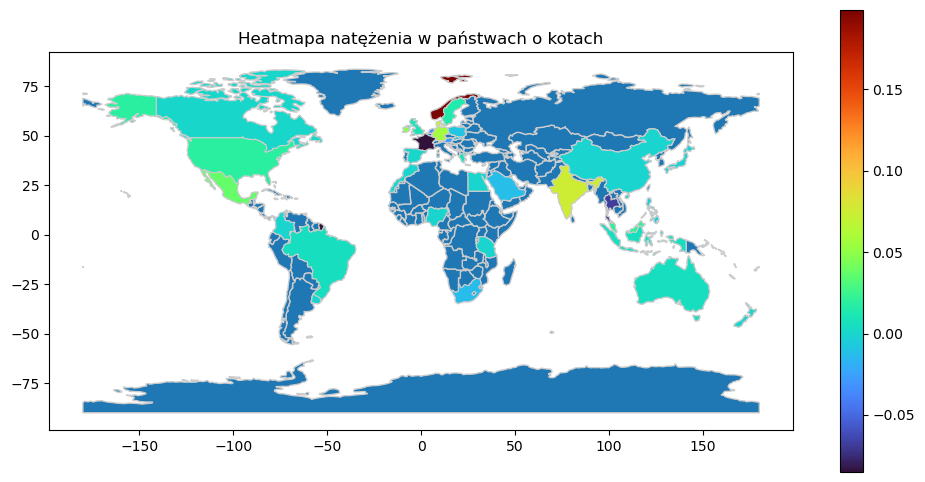

In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Wczytanie granic państw
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

panstwa = np.unique(twitter['Panstwo'].values)
sredni_wynik = []
for panstwo in panstwa:
    sredni_wynik.append(np.mean(twitter['Wynik_opinni'][twitter['Panstwo'] == panstwo]))
    


# Wczytanie danych z natężeniem
data = pd.DataFrame({
    "Panstwo": panstwa,
    "Wynik_opinii": sredni_wynik
})

# Scalanie granic z danymi
world_with_data = world.merge(data, left_on='name', right_on='Panstwo')

# Tworzenie wykresu mapowego
fig, ax = plt.subplots(figsize=(12, 6))

# Tworzenie heatmapy
world.plot(ax=ax, edgecolor='0.8')
world_with_data.plot(column='Wynik_opinii', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Dodanie tytułu
ax.set_title('Heatmapa natężenia w państwach o kotach')

# Ustawienie aspektu na "equal"
#ax.set_aspect("equal")

# Wyświetlenie wykresu
plt.show()

Z mapki możemy zauważyć, że opinie są pozytywne, ale bez szału (prócz Norwegii :)) Niestety najmniej lubią kotki we Francji i Tajlandii. Dokładne wyniki przedstawię poniżej:

In [94]:
data.sort_values(by = 'Wynik_opinii')

,Panstwo,Wynik_opinii
10,France,-0.085027
32,Thailand,-0.068100
20,Netherlands,-0.038887
6,Czech Republic,-0.029479
1,Austria,-0.028163
28,South Africa,-0.013655
26,Saudi Arabia,-0.012306
27,Slovakia,-0.009626
25,Poland,-0.008791
24,Philippines,-0.004231


Teraz zobaczymy jak mapa prezentuje się dla piesków:

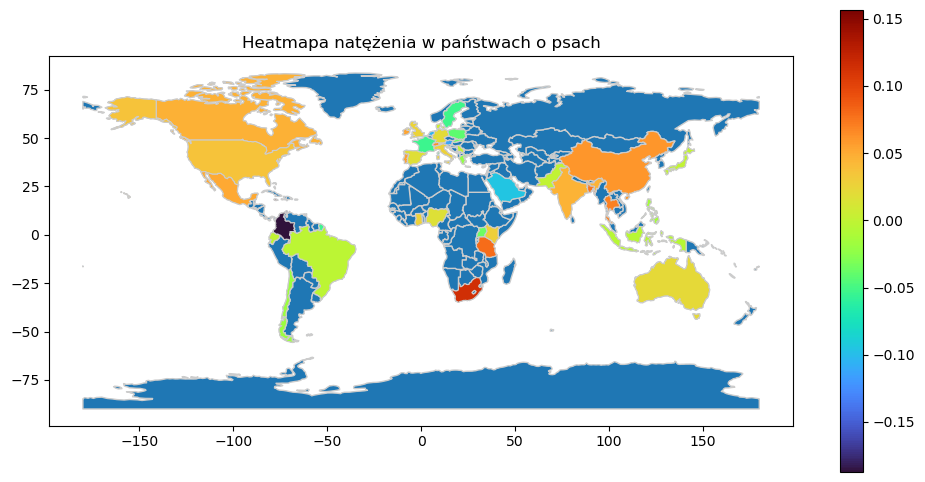

In [96]:
import geopandas as gpd
import matplotlib.pyplot as plt

panstwa = np.unique(twitterp['Panstwo'].values)
sredni_wynik = []
for panstwo in panstwa:
    sredni_wynik.append(np.mean(twitterp['Wynik_opinni'][twitterp['Panstwo'] == panstwo]))
    
# Wczytanie granic państw
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Wczytanie danych z natężeniem
data = pd.DataFrame({
    "Panstwo": panstwa,
    "Wynik_opinii": sredni_wynik
})

# Scalanie granic z danymi
world_with_data = world.merge(data, left_on='name', right_on='Panstwo')

# Tworzenie wykresu mapowego
fig, ax = plt.subplots(figsize=(12, 6))

# Tworzenie heatmapy
world.plot(ax=ax, edgecolor='0.8')
world_with_data.plot(column='Wynik_opinii', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Dodanie tytułu
ax.set_title('Heatmapa natężenia w państwach o psach')

# Ustawienie aspektu na "equal"
#ax.set_aspect("equal")

# Wyświetlenie wykresu
plt.show()

Sprawa pieskowa wygląda o wiele bardziej pozytywnie. Najmniej miłości przekazuje Kolumbia i Holandia. Pieski otrzymują najwięcej miłości i Afryce Południowej, potem Ameryce Północnej oraz w Chinach. Europa wypada średnio - love hate relation ;)

In [98]:
data.sort_values(by = 'Wynik_opinii')

,Panstwo,Wynik_opinii
7,Colombia,-0.187293
1,Austria,-0.112368
23,Netherlands,-0.104159
29,Saudi Arabia,-0.095317
11,France,-0.054317
34,Sweden,-0.051700
27,Poland,-0.041660
39,Uganda,-0.036536
31,Slovakia,-0.036000
14,Greece,-0.022789


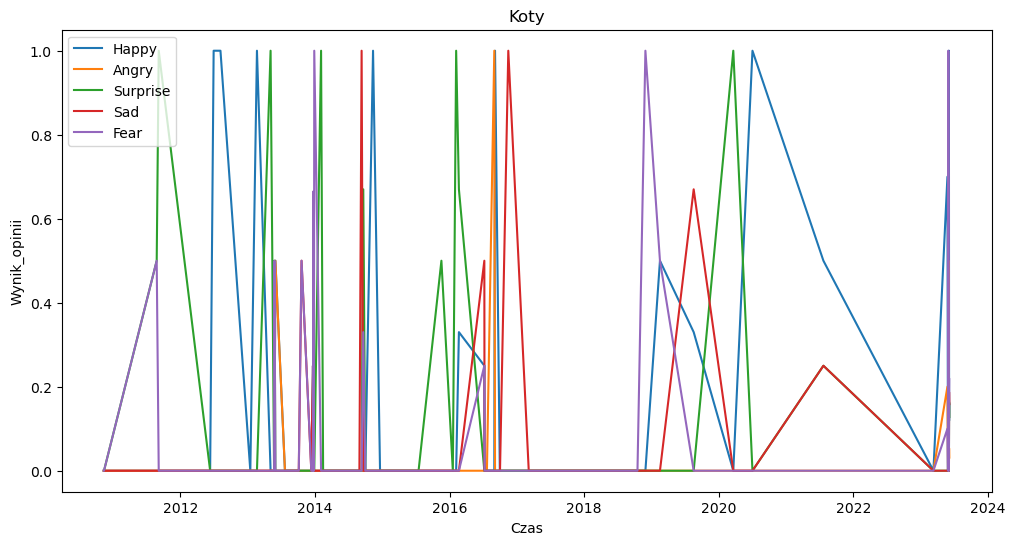

In [122]:
# Line plot

Czas = twitter['Datetime'][twitter['Język'] == 'en'].sort_values().dt.date.unique()

Happy = []
for czas in Czas:
    hap = 0
    for emocje in twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')]:
        hap += emocje['Happy'] / len(twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')])
    Happy.append(hap)

Angry = []
for czas in Czas:
    ang = 0
    for emocje in twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')]:
        ang += emocje['Angry'] / len(twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')])
    Angry.append(ang)

Surprise = []
for czas in Czas:
    sur = 0
    for emocje in twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')]:
        sur += emocje['Surprise'] / len(twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')])
    Surprise.append(sur)

Sad = []
for czas in Czas:
    sad = 0
    for emocje in twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')]:
        sad += emocje['Sad'] / len(twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')])
    Sad.append(sad)

Fear = []
for czas in Czas:
    fear = 0
    for emocje in twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')]:
        fear += emocje['Fear'] / len(twitter['Emocje'][(twitter['Datetime'].dt.date == czas) & (twitter['Język'] == 'en')])
    Fear.append(fear)



fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas, Happy, label = 'Happy')
ax.plot(Czas, Angry, label = 'Angry')
ax.plot(Czas, Surprise, label = 'Surprise')
ax.plot(Czas, Sad, label = 'Sad')
ax.plot(Czas, Fear, label = 'Fear')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Koty')
plt.legend()
plt.show()

Kotki są połaczeniem wszystkich emocji. Jednak najczęściej królują radość, zaskoczenie i strach. Pomiędzy 2016-2017 jest wzrost cechy angry - był to czas hejtu na wykonawce "Doja CAT", która nieszczęsnym trafem stała się naszym celem choć nie jest kotem ;) tak to za dużo złości nasze czworonogi nie otrzymują. Całokształt myśle że ma wydzwięk pozytywny. Pośród ogłoszeń były też posty o stracie bądź zgunieniu pupila - stąd też tyle fioletowego koloru, ale miejmy nadzieję, że sie znalazły całe i zdrowe. Też ilość smutnych emocji może wynikać z próśb o wpłacanie pieniążków na zbiórki mające na celu pomoc różnym zwierzaczkom.

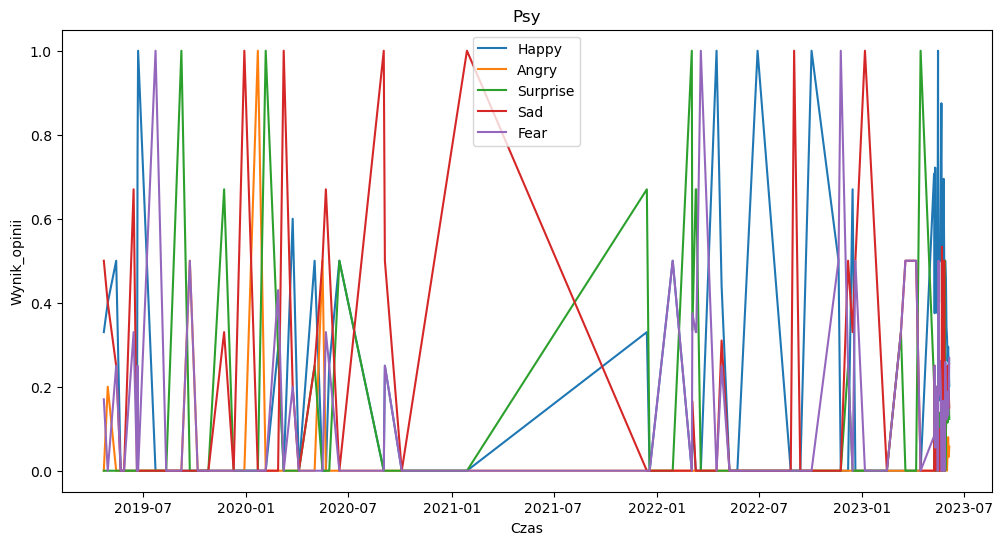

In [123]:
# Line plot

Czas = twitterp['Datetime'][twitterp['Język'] == 'en'].sort_values().dt.date.unique()

Happy = []
for czas in Czas:
    hap = 0
    for emocje in twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')]:
        hap += emocje['Happy'] / len(twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')])
    Happy.append(hap)

Angry = []
for czas in Czas:
    ang = 0
    for emocje in twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')]:
        ang += emocje['Angry'] / len(twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')])
    Angry.append(ang)

Surprise = []
for czas in Czas:
    sur = 0
    for emocje in twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')]:
        sur += emocje['Surprise'] / len(twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')])
    Surprise.append(sur)

Sad = []
for czas in Czas:
    sad = 0
    for emocje in twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')]:
        sad += emocje['Sad'] / len(twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')])
    Sad.append(sad)

Fear = []
for czas in Czas:
    fear = 0
    for emocje in twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')]:
        fear += emocje['Fear'] / len(twitterp['Emocje'][(twitterp['Datetime'].dt.date == czas) & (twitterp['Język'] == 'en')])
    Fear.append(fear)



fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas, Happy, label = 'Happy')
ax.plot(Czas, Angry, label = 'Angry')
ax.plot(Czas, Surprise, label = 'Surprise')
ax.plot(Czas, Sad, label = 'Sad')
ax.plot(Czas, Fear, label = 'Fear')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Psy')
plt.legend()
plt.show()

U psów zaś jest rollercoster emocjonalny. Przeważa wiecej smutku - jest to też konsekwencja języka i wyrażeń typu "wieszać psy na kimś". Widzimy jednak dużo radości, zaskoczenia i smutku. Smutek króluje w czasach kryzysu - domyślam się, że było to spowodowane lockdownem, brakiem wystarczających środków i pomocy. Niestety liczby nie kłamią i pieski statystyznie sprawiają więcej radości.

Chciałam poznać też zdanie Facebookowiczów, ale niestety przez ostatnią zmiane prywatności było to niewykonalne dla mnie :(

# Facebook

In [16]:
import datetime
import snscrape.modules.facebook as snsfacebook
sinceDate = datetime.date(2020, 1, 1)
untilDate = datetime.date(2020, 2, 1)
for post in snsfacebook.FacebookGroupScraper('www.facebook.com/CatsBestPL').get_items():
    if post.date < sinceDate:
        # This should be safe, but I'm not 100 % sure whether Facebook always returns posts in reverse chronological order.
        break
    if post.date >= untilDate:
        continue
    if not post.content or 'keyword' not in post.content:
        continue
    # Do something with the posts of interest...

Group does not exist


# Redit

In [17]:
import requests

#requestuje dostęp do strony, żeby pobrać wpisy za pomocą mojego konta

CLIENT_ID = 'j_WjIBvJNysNuXHd_KyzfA'
SECRET_KEY = 'keESr8LWItS_LvpMI9MlPsOZ-pXK4A'

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, SECRET_KEY)

data = {
    'grant_type': 'password',
    'username': 'Redit_api',
    'password': "Rodosx99"
}

headers = {'User-Agent': 'MyAPI/0.0.1'}

res = requests.post('https://www.reddit.com/api/v1/access_token',
                   auth = auth, data = data, headers = headers)

TOKEN = res.json()['access_token']

In [18]:
headers['Authorization'] = f'bearer {TOKEN}'

In [19]:
requests.get('https://oauth.reddit.com/api/v1/me',
             headers = headers).json()

{'is_employee': False,
 'seen_layout_switch': False,
 'has_visited_new_profile': False,
 'pref_no_profanity': True,
 'has_external_account': False,
 'pref_geopopular': '',
 'seen_redesign_modal': False,
 'pref_show_trending': True,
 'subreddit': {'default_set': True,
  'user_is_contributor': False,
  'banner_img': '',
  'restrict_posting': True,
  'user_is_banned': False,
  'free_form_reports': True,
  'community_icon': None,
  'show_media': True,
  'icon_color': '',
  'user_is_muted': None,
  'display_name': 'u_Redit_api',
  'header_img': None,
  'title': '',
  'coins': 0,
  'previous_names': [],
  'over_18': False,
  'icon_size': [256, 256],
  'primary_color': '',
  'icon_img': 'https://styles.redditmedia.com/t5_8g7mj9/styles/profileIcon_snoo46796a71-b372-4259-bfe9-a42d6b806521-headshot.png?width=256&amp;height=256&amp;crop=256:256,smart&amp;v=enabled&amp;s=74a124b620455ae82e0c6a17ceb46b3d29a86c0f',
  'description': '',
  'allowed_media_in_comments': [],
  'submit_link_label': '',
  

Co możemy wyciągnąć na naszej strony?

In [33]:
path = 'https://oauth.reddit.com/r/' + 'kot' + '/hot'
res = requests.get(path, headers = headers, params = {'limit': '10000'})
i=0
for post in res.json()['data']['children']:
    if i >= 1:
        break
    print(post['data'].keys())
    print(post['data']['created'])
    print(post['data']['created_utc'])
    i+=1
    


dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'upvote_ratio', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'is_created_from_ads_ui', 'author_premium', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'removed_by_category', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'sel

In [20]:
def get_reddit(subreddit, limit):
    path = 'https://oauth.reddit.com/r/' + subreddit #+ '/hot'
    res = requests.get(path, headers = headers, params = {'limit': '10000'})#'after': 't3_13kmhgi'
    reddit_list = []
    com = pd.DataFrame(columns = ['author','created', 'body'])
    default_stopwords = stopwords.words('english') 
    additional_stopwords = ['``', '.', '\'\'',',','...','?',':','(',')'] # //, '@' , '!', '#'
    stopwords_list = default_stopwords + additional_stopwords
    lemmatizer = WordNetLemmatizer()
    sia = SentimentIntensityAnalyzer()
    
    i = 0
    for post in res.json()['data']['children']: #rozpakowuje requesty przez json'a (słownik w słowniku)
        if i >= limit:
            break
        if post['data']['selftext'] != '':
            try:
                language = detect(str(post['data']['selftext']))
            except:
                language = "not_found"
            subreddit = post['data']['subreddit'],
            title = post['data']['title'],
            selftext = post['data']['selftext']
            created = post['data']['created']
            tokens = word_tokenize(str(selftext).lower())
            filtered_tokens = [token for token in tokens if token not in stopwords_list]
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
            suma = 0
            for token in lemmatized_tokens:
                suma += sia.polarity_scores(token)['compound'] / len(lemmatized_tokens)
            emocje = get_emotion(selftext)
            reddit_list.append([language, subreddit, created, title, selftext, tokens, filtered_tokens, 
                               lemmatized_tokens, suma, emocje])
            i += 1

    reddit = pd.DataFrame(reddit_list, columns=['Język', 'Subreddit', 'Czas', 'Tutuł', 'Selftext', 'Tokeny', 
                                               'Filtrowane_tokeny', 'Lematyzacja',
                                               'Wynik_opinii', 'Emocje'])
    return reddit

In [21]:
red = get_reddit('cats',1000)

In [22]:
red

,Język,Subreddit,Czas,Tutuł,Selftext,Tokeny,Filtrowane_tokeny,Lematyzacja,Wynik_opinni,Emocje
0,en,"(cats,)",1.685928e+09,"(8 lives left,)",I found this lil guy on the side of the street...,"[i, found, this, lil, guy, on, the, side, of, ...","[found, lil, guy, side, street, disoriented, g...","[found, lil, guy, side, street, disoriented, g...",0.037479,"{'Happy': 0.0, 'Angry': 0.22, 'Surprise': 0.0,..."
1,en,"(cats,)",1.685923e+09,"(So I just rescued….this 😳,)",I dont know her name 😢,"[i, dont, know, her, name, 😢]","[dont, know, name, 😢]","[dont, know, name, 😢]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
2,en,"(cats,)",1.685892e+09,"(I had to share Phoebe because this.,)",She can do this for 30 minutes. She is also v...,"[she, can, do, this, for, 30, minutes, ., she,...","[30, minutes, also, sweet, vocal, little, marg...","[30, minute, also, sweet, vocal, little, marge...",0.045880,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
3,en,"(cats,)",1.685885e+09,"(I made my cat a jumper,)",I think everyone needs to see the jumper I cro...,"[i, think, everyone, needs, to, see, the, jump...","[think, everyone, needs, see, jumper, crochete...","[think, everyone, need, see, jumper, crocheted...",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
4,en,"(cats,)",1.685947e+09,(New baby girl coming home soon… Need help wit...,Hello all! I have a female Cornish Rex kitten ...,"[hello, all, !, i, have, a, female, cornish, r...","[hello, !, female, cornish, rex, kitten, comin...","[hello, !, female, cornish, rex, kitten, comin...",0.019784,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.5,..."
5,en,"(cats,)",1.685940e+09,"(Marigold is 3 today!!!,)",She’s the absolute love of my life!,"[she, ’, s, the, absolute, love, of, my, life, !]","[’, absolute, love, life, !]","[’, absolute, love, life, !]",0.127380,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.0,..."
6,en,"(cats,)",1.685893e+09,"(Sawdust, aka Dusty, our chonky as hell shop c...",We already have 4 rescue cats and a dog inside...,"[we, already, have, 4, rescue, cats, and, a, d...","[already, 4, rescue, cats, dog, inside, loves,...","[already, 4, rescue, cat, dog, inside, love, w...",0.008840,"{'Happy': 0.22, 'Angry': 0.11, 'Surprise': 0.3..."
7,en,"(cats,)",1.685934e+09,"(Just wanted to show you my cat..,)",Called my cats name and this is what happened ...,"[called, my, cats, name, and, this, is, what, ...","[called, cats, name, happened, looked, ..]","[called, cat, name, happened, looked, ..]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
8,en,"(cats,)",1.685939e+09,"(Just adopted this lil dude earlier today 😍😍.,)","I lost my best buddy Blooregard Q. Kazoo, a gr...","[i, lost, my, best, buddy, blooregard, q., kaz...","[lost, best, buddy, blooregard, q., kazoo, gre...","[lost, best, buddy, blooregard, q., kazoo, gre...",0.017390,"{'Happy': 0.04, 'Angry': 0.04, 'Surprise': 0.1..."
9,en,"(cats,)",1.685946e+09,"(my three kitties 💗,)","Mya, Squeak and Ash (from left to right)","[mya, ,, squeak, and, ash, (, from, left, to, ...","[mya, squeak, ash, left, right]","[mya, squeak, ash, left, right]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."


In [23]:
subreditty = ['cat', 'kitties', 'catperson', 'thebestcat', 'kitty', 'Kitten', 'Pussycat']
for s in subreditty:
    r = get_reddit(s,1000)
    red = pd.concat([red,r])

In [24]:
red

,Język,Subreddit,Czas,Tutuł,Selftext,Tokeny,Filtrowane_tokeny,Lematyzacja,Wynik_opinni,Emocje
0,en,"(cats,)",1.685928e+09,"(8 lives left,)",I found this lil guy on the side of the street...,"[i, found, this, lil, guy, on, the, side, of, ...","[found, lil, guy, side, street, disoriented, g...","[found, lil, guy, side, street, disoriented, g...",0.037479,"{'Happy': 0.0, 'Angry': 0.22, 'Surprise': 0.0,..."
1,en,"(cats,)",1.685923e+09,"(So I just rescued….this 😳,)",I dont know her name 😢,"[i, dont, know, her, name, 😢]","[dont, know, name, 😢]","[dont, know, name, 😢]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
2,en,"(cats,)",1.685892e+09,"(I had to share Phoebe because this.,)",She can do this for 30 minutes. She is also v...,"[she, can, do, this, for, 30, minutes, ., she,...","[30, minutes, also, sweet, vocal, little, marg...","[30, minute, also, sweet, vocal, little, marge...",0.045880,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
3,en,"(cats,)",1.685885e+09,"(I made my cat a jumper,)",I think everyone needs to see the jumper I cro...,"[i, think, everyone, needs, to, see, the, jump...","[think, everyone, needs, see, jumper, crochete...","[think, everyone, need, see, jumper, crocheted...",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
4,en,"(cats,)",1.685947e+09,(New baby girl coming home soon… Need help wit...,Hello all! I have a female Cornish Rex kitten ...,"[hello, all, !, i, have, a, female, cornish, r...","[hello, !, female, cornish, rex, kitten, comin...","[hello, !, female, cornish, rex, kitten, comin...",0.019784,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.5,..."
...,...,...,...,...,...,...,...,...,...,...
27,en,"(Kitten,)",1.685209e+09,"(Adopted this little guy last night,)",His name is Gus.,"[his, name, is, gus, .]","[name, gus]","[name, gu]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
28,en,"(Kitten,)",1.685214e+09,"(I messed up,)",We took in a kitten that was a few days old. W...,"[we, took, in, a, kitten, that, was, a, few, d...","[took, kitten, days, old, 've, giving, antibio...","[took, kitten, day, old, 've, giving, antibiot...",0.011716,"{'Happy': 0.22, 'Angry': 0.11, 'Surprise': 0.0..."
29,en,"(Kitten,)",1.685158e+09,"(My new kits!,)",the tuxedo &amp; the white kits are coming hom...,"[the, tuxedo, &, amp, ;, the, white, kits, are...","[tuxedo, &, amp, ;, white, kits, coming, home,...","[tuxedo, &, amp, ;, white, kit, coming, home, ...",0.043158,"{'Happy': 0.14, 'Angry': 0.0, 'Surprise': 0.43..."
30,en,"(Kitten,)",1.685106e+09,"(Sick kitten,)","Hello, recently got a little male kitten. He i...","[hello, ,, recently, got, a, little, male, kit...","[hello, recently, got, little, male, kitten, p...","[hello, recently, got, little, male, kitten, p...",-0.030107,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ..."


Zamiana dat - były podane w liczbie, musiałam zamienić na daty 

In [25]:
df_time_cleaned = red.copy()
df_time_cleaned['Czas'] = pd.to_datetime(df_time_cleaned['Czas'], unit = 's', utc = True).dt.tz_convert('Europe/Warsaw')
df_time_cleaned = df_time_cleaned.sort_values(by = 'Czas', ascending = False)
red = df_time_cleaned
red = red.reset_index()

In [50]:
red['Czas'] = red['Czas'].dt.date

In [51]:
red

,index,Język,Subreddit,Czas,Tutuł,Selftext,Tokeny,Filtrowane_tokeny,Lematyzacja,Wynik_opinni,Emocje
0,14,en,"(cats,)",2023-06-05,"(How big do ragdolls get?,)",Our male ragdoll is currently 13 months old an...,"[our, male, ragdoll, is, currently, 13, months...","[male, ragdoll, currently, 13, months, old, ne...","[male, ragdoll, currently, 13, month, old, nea...",0.005717,"{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.0,..."
1,20,en,"(cats,)",2023-06-05,"(Community cats,)",Two adult toms on either side not amused by hu...,"[two, adult, toms, on, either, side, not, amus...","[two, adult, toms, either, side, amused, hungr...","[two, adult, tom, either, side, amused, hungry...",0.076636,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
2,29,en,"(cats,)",2023-06-05,"(My cat died,)",My cat Mike died. He was found in a small stre...,"[my, cat, mike, died, ., he, was, found, in, a...","[cat, mike, died, found, small, stream, probab...","[cat, mike, died, found, small, stream, probab...",-0.065495,"{'Happy': 0.0, 'Angry': 0.17, 'Surprise': 0.0,..."
3,24,en,"(cats,)",2023-06-05,"(Cats nipped ,)","Skye, Freyr-Floof and Loki got catnip mice 🤣","[skye, ,, freyr-floof, and, loki, got, catnip,...","[skye, freyr-floof, loki, got, catnip, mice, 🤣]","[skye, freyr-floof, loki, got, catnip, mouse, 🤣]",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
4,22,en,"(cats,)",2023-06-05,"(My boys :),)",Orange one is Reggie and grey one is Ivan. Reg...,"[orange, one, is, reggie, and, grey, one, is, ...","[orange, one, reggie, grey, one, ivan, reggie,...","[orange, one, reggie, grey, one, ivan, reggie,...",-0.064836,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.25,..."
...,...,...,...,...,...,...,...,...,...,...,...
80,0,fi,"(kitties,)",2023-05-22,"(Tikki the kitty,)",The pretty kitty,"[the, pretty, kitty]","[pretty, kitty]","[pretty, kitty]",0.246950,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
81,2,en,"(kitties,)",2023-05-21,(Just got my first kitty today! Would love to ...,"This is my new baby boy, he is two months old ...","[this, is, my, new, baby, boy, ,, he, is, two,...","[new, baby, boy, two, months, old, shelter, na...","[new, baby, boy, two, month, old, shelter, nam...",0.070675,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ..."
82,3,not_found,"(kitties,)",2023-05-20,(My little boy when he was 2 month old!😍 isn´t...,[https://i.imgur.com/9xJQzVT.png](https://i.im...,"[[, https, :, //i.imgur.com/9xjqzvt.png, ], (,...","[[, https, //i.imgur.com/9xjqzvt.png, ], https...","[[, http, //i.imgur.com/9xjqzvt.png, ], http, ...",0.000000,"{'Happy': 0, 'Angry': 0, 'Surprise': 0, 'Sad':..."
83,4,en,"(kitties,)",2023-05-16,"(Wilson,)",He’s a happy boy🐈‍⬛,"[he, ’, s, a, happy, boy🐈‍⬛]","[’, happy, boy🐈‍⬛]","[’, happy, boy🐈‍⬛]",0.190633,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ..."


Wykresy opinii o kotkach uśrednione w dniu opublikowania:

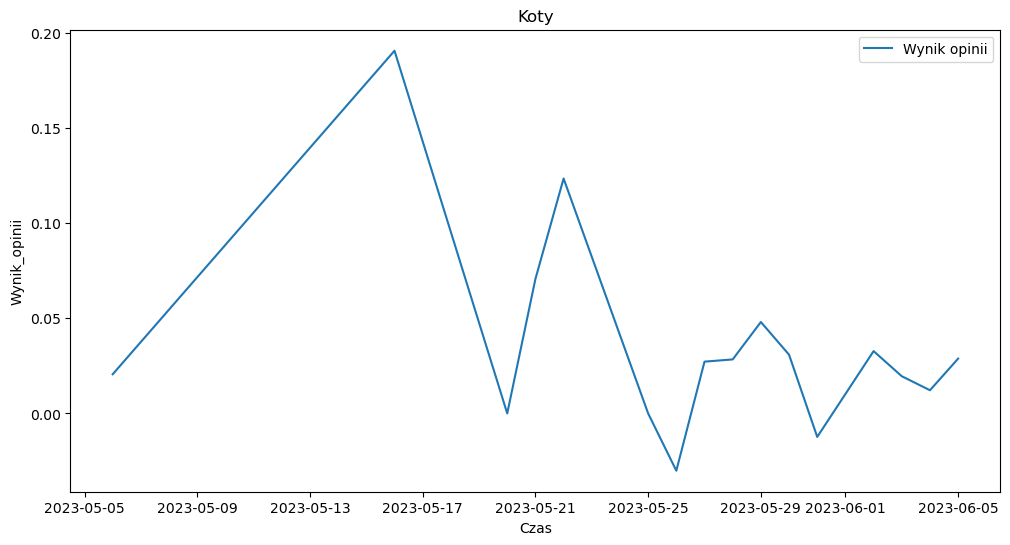

In [76]:
# Line plot

Czas = red['Czas'].unique()

Wynik = []
for czas in Czas:
    wyn = 0
    for w in red['Wynik_opinni'][red['Czas'] == czas]:
        wyn += w / len(red['Wynik_opinni'][red['Czas'] == czas])
    Wynik.append(wyn)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas, Wynik, label = 'Wynik opinii')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Koty')
plt.legend()
plt.show()

Jak widać, opinia zależy od dnia i humoru, ale ogólnie jest pozytywna - podjrzewam, że jak nic nie robią to kochamy, a jak nabroją to się wkurzamy

Wykresy emocji o kotkach, sprawdźmy:

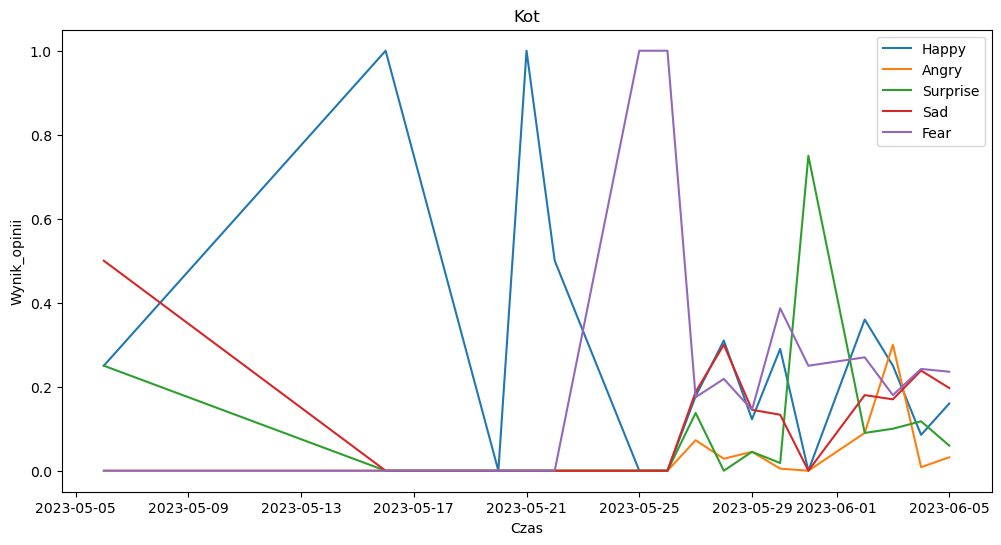

In [119]:
# Line plot

Czas = red['Czas'].unique()

Happy = []
for czas in Czas:
    hap = 0
    for emocje in red['Emocje'][red['Czas'] == czas]:
        hap += emocje['Happy'] / len(red['Emocje'][red['Czas'] == czas])
    Happy.append(hap)

Angry = []
for czas in Czas:
    ang = 0
    for emocje in red['Emocje'][red['Czas'] == czas]:
        ang += emocje['Angry'] / len(red['Emocje'][red['Czas'] == czas])
    Angry.append(ang)

Surprise = []
for czas in Czas:
    sur = 0
    for emocje in red['Emocje'][red['Czas'] == czas]:
        sur += emocje['Surprise'] / len(red['Emocje'][red['Czas'] == czas])
    Surprise.append(sur)

Sad = []
for czas in Czas:
    sad = 0
    for emocje in red['Emocje'][red['Czas'] == czas]:
        sad += emocje['Sad'] / len(red['Emocje'][red['Czas'] == czas])
    Sad.append(sad)

Fear = []
for czas in Czas:
    fear = 0
    for emocje in red['Emocje'][red['Czas'] == czas]:
        fear += emocje['Fear'] / len(red['Emocje'][red['Czas'] == czas])
    Fear.append(fear)



fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas, Happy, label = 'Happy')
ax.plot(Czas, Angry, label = 'Angry')
ax.plot(Czas, Surprise, label = 'Surprise')
ax.plot(Czas, Sad, label = 'Sad')
ax.plot(Czas, Fear, label = 'Fear')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Kot')
plt.legend()
plt.show()

Emocje są bardzo różne - ale widzimy, że przeważa radość. Czasami też niespodziewaność. Jednak pojawia się też strach, smutek i złość. Domyślam się, że wynika to ze spontaniczności kociego zachowania, czasami lubią sobie coś zrzucić z półki. Ocena ta nie zawsze jest dokładna, niestety paczki jeszcze nie są w stanie wyszukać sarkazmów, dlatego wyniki mogą być trochę przekłamane.

In [82]:
redp = get_reddit('dogs',1000)

In [83]:
subreditty = ['dog', 'dogiesies', 'dogperson', 'thebestdog', 'doggy', 'puppy', 'doggo']
for s in subreditty:
    r = get_reddit(s,1000)
    redp = pd.concat([redp,r])

In [84]:
df_time_cleaned = redp.copy()
df_time_cleaned['Czas'] = pd.to_datetime(df_time_cleaned['Czas'], unit = 's', utc=True).dt.tz_convert('Europe/Warsaw')
df_time_cleaned = df_time_cleaned.sort_values(by = 'Czas', ascending = False)
redp = df_time_cleaned
redp = redp.reset_index()

In [85]:
redp['Czas'] = redp['Czas'].dt.date

Jak wygląda poziom pozytywności u piesków?

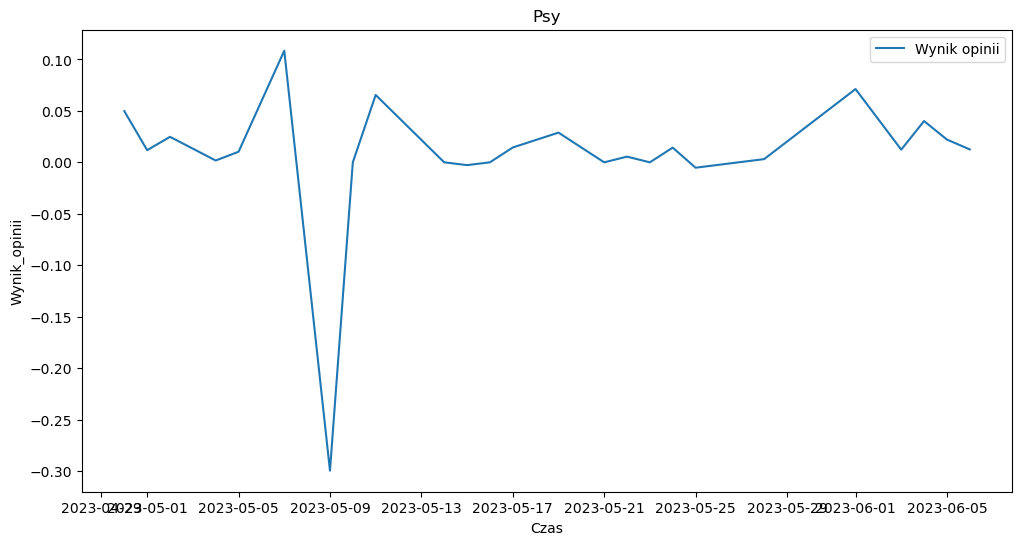

In [91]:
# Line plot

Czas = redp['Czas'].unique()

Wynik = []
for czas in Czas:
    wyn = 0
    for w in redp['Wynik_opinni'][redp['Czas'] == czas]:
        wyn += w / len(redp['Wynik_opinni'][redp['Czas'] == czas])
    Wynik.append(wyn)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas[0:-2], Wynik[0:-2], label = 'Wynik opinii')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Psy')
plt.legend()
plt.show()

Pieski zaliczają swój spadek :( Kotki mają bardziej pozytywną opinie - w przeciwieństwie do Tweeterowców, tam sytuacja bardziej na korzyść kotków.

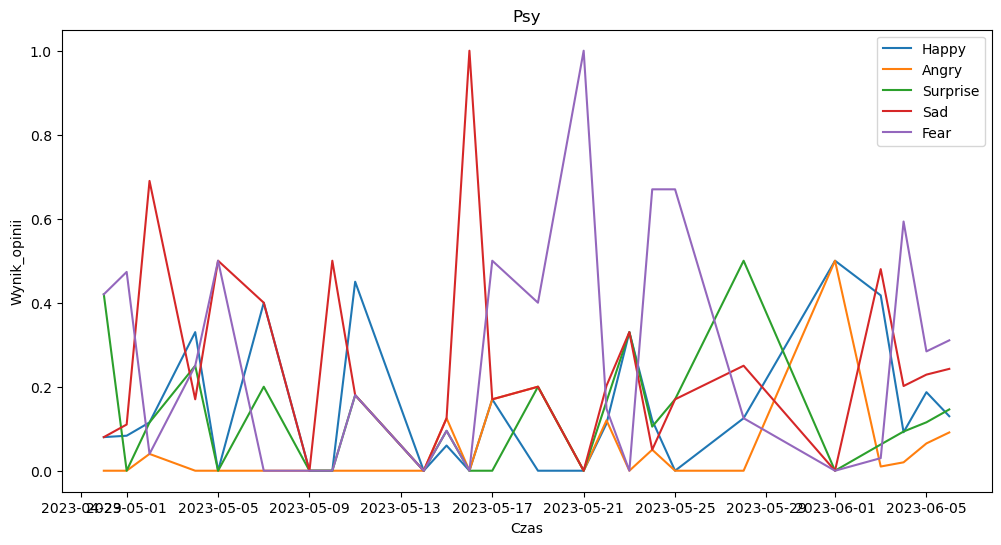

In [120]:
# Line plot

Czas = redp['Czas'].unique()

Happy = []
for czas in Czas:
    hap = 0
    for emocje in redp['Emocje'][redp['Czas'] == czas]:
        hap += emocje['Happy'] / len(redp['Emocje'][redp['Czas'] == czas])
    Happy.append(hap)

Angry = []
for czas in Czas:
    ang = 0
    for emocje in redp['Emocje'][redp['Czas'] == czas]:
        ang += emocje['Angry'] / len(redp['Emocje'][redp['Czas'] == czas])
    Angry.append(ang)

Surprise = []
for czas in Czas:
    sur = 0
    for emocje in redp['Emocje'][redp['Czas'] == czas]:
        sur += emocje['Surprise'] / len(redp['Emocje'][redp['Czas'] == czas])
    Surprise.append(sur)

Sad = []
for czas in Czas:
    sad = 0
    for emocje in redp['Emocje'][redp['Czas'] == czas]:
        sad += emocje['Sad'] / len(redp['Emocje'][redp['Czas'] == czas])
    Sad.append(sad)

Fear = []
for czas in Czas:
    fear = 0
    for emocje in redp['Emocje'][redp['Czas'] == czas]:
        fear += emocje['Fear'] / len(redp['Emocje'][redp['Czas'] == czas])
    Fear.append(fear)



fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Czas[0:-2], Happy[0:-2], label = 'Happy')
ax.plot(Czas[0:-2], Angry[0:-2], label = 'Angry')
ax.plot(Czas[0:-2], Surprise[0:-2], label = 'Surprise')
ax.plot(Czas[0:-2], Sad[0:-2], label = 'Sad')
ax.plot(Czas[0:-2], Fear[0:-2], label = 'Fear')
plt.xlabel('Czas')
plt.ylabel('Wynik_opinii')
plt.title('Psy')
plt.legend()
plt.show()



Hmmm... Radość ginie w cieniu smutku i strachu... Może wyglądają groźniej i są bardziej niebezpieczne? Zaskoczenie też ginie. Co dziwne strach i smutek nie idą w parze ze złością. Poziom strachu może wynikać z tego, że dużo wpisów było odnośnie rad co do wychowania i obycia. Złość w okolicach początku czerwca jest związana z emocjami politycznymi i przezwiskami związanymi z psami.

Jako posiadaczka psa i kota nie jestem zaskoczona rozbieżnością. Oba "tematy" to istny rollercoster emocjonalny. Sama nie byłabym w stanie jednoznacznie określic moich uczuć - myśle że wiecej negatywnych powoduje jednak pies - logiczne jest to bardziej aktywne i wymagajace stworzenie. Dlatego zaskoczyła mnie bardzo heatmapa dla kotów z tweetera - myślałam, że będa cieszyć się większym powodzeniem. Też badania nie są do końca "adekwatne" ponieważ jak wspominałam wyżej, program nie rozumie sarkazmu, nie odróżnia tematu, że Doja Cat nie jest kotem, porównywania aktualnej władzy do psów - jednak to nie były aspekty, które chciałam rozważać a niestety nie jeden taki się przewinął. 

Trafiłam włąsnie na bardzo dużo nieporządanych tweetów typu :
    
    Warto przypomnieć, że pozbawianie osób nieheteroseksualnych praw to podstawowa część rosyjskiej polityki. 
    Dlatego rząd ZJEP może #wypierdalać do Putina. Tam jest wasze miejsce.
    @DoRzeczy_pl @SlawomirNitras Czemu małżeństwa piszecie w cudzysłowie?
    W XXI wieku równość małżeńska istnieje od ponad dwóch dekad, obecnie już w 35 wysokorozwiniętych krajach świata. 
    Możecie sobie szczekać, pieski Putina. https://t.co/00VAJGgrP8
    
    lub
    
    @szejnfeld Pieski kaczyńskiego gryzą😡😡😡😡👎 https://t.co/3karxNLdPp
        
Niestety zaburzały one agresywne emocje w stsounku do prawdziwych czworonogów.